# Import necessary libraries

In [ ]:
!pip install nlopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.7/423.7 kB 3.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
#import nlopt
import json
import math
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.integrate import simps
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from google.colab import files

# Create necessary DataFrames

In [ ]:
# Upload all the necessary files
uploaded = files.upload()

Saving NMs_Database.xlsx to NMs_Database.xlsx
Saving Organ_percent_BW.xlsx to Organ_percent_BW.xlsx


In [ ]:
# Create DataFrame Experimental_details
df_Experimental_details = pd.read_excel("NMs_Database.xlsx", "Experiment_details", index_col=None, na_values=["NA"])

# Create DataFrame Physchem_properties
df_Physchem_properties = pd.read_excel("NMs_Database.xlsx", "Physchem_properties", index_col=None, na_values=["NA"])

# Create DataFrame Time_points
df_Time_points = pd.read_excel("NMs_Database.xlsx", "Time_points", index_col=None, na_values=["NA"])

# Create DataFrame Tissues
df_Tissues = pd.read_excel("NMs_Database.xlsx", "Tissues", index_col=None, na_values=["NA"])

# Create DataFrame Concentrations
df_Concentrations = pd.read_excel("NMs_Database.xlsx", "Concentrations", index_col=None, na_values=["NA"])

# Create DataFrame Organ_percent_BW
df_Organ_percent_BW = pd.read_excel("Organ_percent_BW.xlsx", index_col=None, na_values=["NA"])


# Process 'Weight_g' from DataFrame Experimental_details

In [ ]:
# Check how many NaN values exist in 'Weight_g'
count_NaN = df_Experimental_details['Weight_g'].isna().sum()
print("Number of NaN values in the 'Weight_g' column:", count_NaN)

# Find the mean value in 'Weight_g' excluding NaN values
mean_weight = df_Experimental_details['Weight_g'].dropna().mean()

# Iterate through Weight_g' column to replace NaN values
for index, row in df_Experimental_details.iterrows():
    # Check if 'Weight_g' is NaN
    if pd.isnull(row['Weight_g']):
        # Check if 'Age_weeks' is also NaN
        if pd.isnull(row['Age_weeks']):
            # Replace NaN 'Weight_g' with the mean weight
            df_Experimental_details.at[index, 'Weight_g'] = mean_weight
            #print(f"for index: {index} weight: {df_Experimental_details.at[index, 'Weight_g']}")
        else:
            # Replace NaN 'Weight_g' based on 'Sex' and 'Age_weeks'
            if row['Sex'] == 'Male' or pd.isnull(row['Sex']):
                df_Experimental_details.at[index, 'Weight_g'] = 0.68 * row['Age_weeks'] + 18.98
            elif row['Sex'] == 'Female':
                df_Experimental_details.at[index, 'Weight_g'] = 0.50 * row['Age_weeks'] + 15.61

# Check the updated 'Weight_g'
count_nan = df_Experimental_details['Weight_g'].isna().sum()
print("Number of NaN values in the updated 'Weight_g' column:", count_nan)

Number of NaN values in the 'Weight_g' column: 191
Number of NaN values in the updated 'Weight_g' column: 0


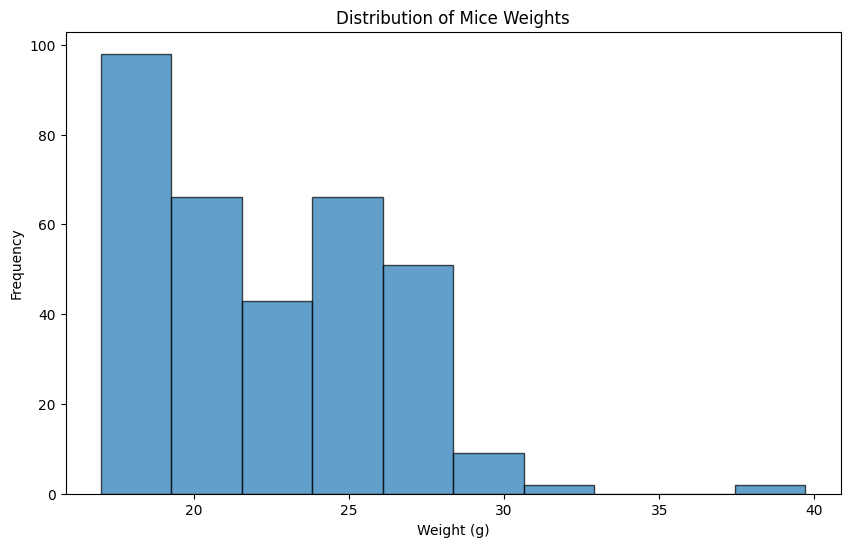

In [ ]:
# Check the distribution of mice weights
plt.figure(figsize=(10, 6))
plt.hist(df_Experimental_details['Weight_g'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribution of Mice Weights')
plt.xlabel('Weight (g)')
plt.ylabel('Frequency')
plt.show()

# Process 'Dose_units' from DataFrame Experimental_details

## Find unique 'Dose_units' values to decide base unit

In [ ]:
# Check unique 'Dose_units'
unique_Dose_units = df_Experimental_details['Dose_units'].unique()

# Create DataFrame unique_Dose_units
df_unique_Dose_units = pd.DataFrame({'Unique Dose units': unique_Dose_units})

# Check the DataFrame unique_Dose_units
df_unique_Dose_units

,Unique Dose units
0,mg/kg
1,mg
2,ug
3,particles/ml
4,uCi
5,MBq
6,NPs
7,kBq
8,NPs/ml
9,mg/g


### Decision: 'mg' and 'MBq' as base units for 'Dose_units' values in DataFrame Experimental_details

## Create a new DataFrame containing only the 'Dose_units' which need conversion

In [ ]:
# All 'Dose_unit' values should be 'mg' OR 'MBq'

# Create filtered DataFrame Experimental_details
filtered_df_Experimental_details = df_Experimental_details.loc[~df_Experimental_details['Dose_units'].isin(['mg', 'MBq'])]

# Check the filtered Dataframe Experimental_details
filtered_df_Experimental_details['Dose_units'].unique()

array(['mg/kg', 'ug', 'particles/ml', 'uCi', 'NPs', 'kBq', 'NPs/ml',
       'mg/g', 'mCi', 'mmol/kg', 'ug/kg', 'MBq/kg'], dtype=object)

## Create an empty dictionary to store:
## 'Study_id' as keys and 'index' as values from filtered Dataframe Experimental_details

In [ ]:
# Create empty dictionary
Study_id_dict = {}

# Iterate through filtered Dataframe Experimental_details
for index, row in filtered_df_Experimental_details.iterrows():
    Study_id = row['Study_id']
    if Study_id not in Study_id_dict:
        Study_id_dict[Study_id] = [index]
    else:
        Study_id_dict[Study_id].append(index)

# Check the dictionary
print(Study_id_dict)

{1: [0, 1, 2], 2: [3], 3: [4], 5: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], 6: [45], 7: [46, 47, 48, 49, 50, 51, 52], 8: [53, 54, 55, 56, 57, 58], 9: [59], 10: [60], 11: [61], 12: [62, 63, 64, 65, 66, 67], 13: [68, 69, 70, 71], 16: [77, 78], 17: [79, 80], 19: [85, 86, 87, 88, 89], 20: [90, 91], 21: [92, 93], 22: [94, 95], 23: [96, 97, 98, 99], 24: [100, 101], 25: [102], 27: [108, 109, 110, 111], 29: [114, 115, 116], 30: [117], 31: [118, 119], 32: [120, 121], 33: [122, 123], 34: [124], 35: [125, 126], 37: [129, 130, 131], 39: [137], 44: [154, 155], 45: [156], 47: [161], 48: [162], 49: [163, 164, 165, 166], 50: [167], 54: [173], 59: [196, 197], 62: [205, 206, 207, 208, 209, 210], 67: [220], 69: [223], 72: [228], 73: [229, 230], 74: [231, 232, 233], 75: [234], 77: [236, 237, 238, 239, 240], 79: [242], 80: [243, 244, 245, 246], 81: [247, 248, 249, 250, 251, 252], 84: [261, 262], 86: [265,

## Create a dictionary with unit conversions for 'Dose_units'

In [ ]:
# Create a DataFrame with 'Dose_units' values which need conversion
df_Dose_units_to_conv = pd.DataFrame({'Dose_units_to_conv': filtered_df_Experimental_details['Dose_units'].unique() })
df_Dose_units_to_conv

,Dose_units_to_conv
0,mg/kg
1,ug
2,particles/ml
3,uCi
4,NPs
5,kBq
6,NPs/ml
7,mg/g
8,mCi
9,mmol/kg


In [ ]:
# Create an empty dictionary
Dose_units_to_conv_dict = {}

# Iterate through DataFrame Dose_units_to_conv to get 'Dose_units' values as keys
for index, row in df_Dose_units_to_conv.iterrows():
    Dose_units_to_conv_dict[row['Dose_units_to_conv']] = []

# Check the dictionary
Dose_units_to_conv_dict

{'mg/kg': [],
 'ug': [],
 'particles/ml': [],
 'uCi': [],
 'NPs': [],
 'kBq': [],
 'NPs/ml': [],
 'mg/g': [],
 'mCi': [],
 'mmol/kg': [],
 'ug/kg': [],
 'MBq/kg': []}

Dose units conversions:

*   **mg/kg** * BW/1000(kg) = mg
*  **ug** = μg = 1e-3 mg
*   **particles/ml** * particle_mass (mg) * dose_volume(ml) = mg
*   **uCi** = 0.037 MBq
*  **NPs/ml** * particle_mass (mg) * dose_volume(ml) = mg
* **NPs** * * particle_mass (mg) = mg
* **kBq** = MBq/1000
* **g** = 1000 mg
* **mmol/kg** /1000 * BW/1000(kg) * MW(g/mol) *1000 = mg
* **mmol** /1000 * MW(g/mol) *1000 = mg
* **ug/kg** *1e-3 * BW/1000(kg) = mg
* **MBq/kg** * BW/1000(kg) = mg







In [ ]:
# Function to calculate the mass of each nanoparticle
def particle_mass_calc(index):

  if df_Physchem_properties.at[index, 'Nominal_size_nm'] is not None:
    V_nanoparticle = 4/3 * math.pi * (df_Physchem_properties.at[index, 'Nominal_size_nm']/2)**3 # nm3
  else:
    V_nanoparticle = math.pi * (df_Physchem_properties.at[index, 'Width_nm']/2)**2 * df_Physchem_properties.at[index, 'Length_nm'] # nm3

  # Change from nm3 to ml
  V_nanoparticle *= 1e-21 # ml

  V_material_atom = df_Physchem_properties.at[index, 'Material_molar_mass'] / df_Physchem_properties.at[index, 'Nominal_density_g_cm3'] # g/mol / g/ml -> ml/mol

  number_of_moles = V_nanoparticle / V_material_atom # mol
  particle_mass = number_of_moles * df_Physchem_properties.at[index, 'Material_molar_mass'] * 1000 # mg

  return particle_mass

In [ ]:
# Fill the Dose_units_to_conv_dict with the necessary conversions as values

Dose_units_to_conv_dict['mg/kg'] = lambda row,index: (row['Weight_g']/1000)
Dose_units_to_conv_dict['ug'] = 1/1000
Dose_units_to_conv_dict['uCi'] = 0.037
Dose_units_to_conv_dict['kBq'] = 1/1000
Dose_units_to_conv_dict['mg/g'] = lambda row,index: row['Weight_g']
Dose_units_to_conv_dict['mCi'] = 37
Dose_units_to_conv_dict['g'] = 1000
Dose_units_to_conv_dict['mmol/kg'] = lambda row,index: (1/1000)*(row['Weight_g']/1000)*(df_Physchem_properties['Material_molar_mass'][index]*1000)
Dose_units_to_conv_dict['mmol'] = lambda row,index: (1/1000)*(df_Physchem_properties['Material_molar_mass'][index]*1000)
Dose_units_to_conv_dict['ug/kg'] = lambda row,index: (row['Weight_g']/1000)*(1e-3)
Dose_units_to_conv_dict['MBq/kg'] = lambda row,index: row['Weight_g']/1000

# The conversions with number of nanoparticles need the application of function which calculates the mass of each nanoparticle
Dose_units_to_conv_dict['NPs/ml'] = lambda row,index: row['Dose_volume_ml'] * particle_mass_calc(index)
Dose_units_to_conv_dict['NPs'] = lambda row,index: particle_mass_calc(index)
Dose_units_to_conv_dict['particles/ml'] = lambda row,index: row['Dose_volume_ml'] * particle_mass_calc(index)

In [ ]:
# Check the Dose_units_to_conv_dict
Dose_units_to_conv_dict

{'mg/kg': <function __main__.<lambda>(row, index)>,
 'ug': 0.001,
 'particles/ml': <function __main__.<lambda>(row, index)>,
 'uCi': 0.037,
 'NPs': <function __main__.<lambda>(row, index)>,
 'kBq': 0.001,
 'NPs/ml': <function __main__.<lambda>(row, index)>,
 'mg/g': <function __main__.<lambda>(row, index)>,
 'mCi': 37,
 'mmol/kg': <function __main__.<lambda>(row, index)>,
 'ug/kg': <function __main__.<lambda>(row, index)>,
 'MBq/kg': <function __main__.<lambda>(row, index)>,
 'g': 1000,
 'mmol': <function __main__.<lambda>(row, index)>}

## Make the necessary conversions to 'Dose_units' and 'Dose' values from DataFrame Experimental_details

In [ ]:
# Iterate through DataFrame Experimental_details to make the necessary conversions
for index, row in df_Experimental_details.iterrows():
    conversion_factor = Dose_units_to_conv_dict.get(row['Dose_units'])
    if conversion_factor is not None:
        # Check if conversion factor is callable (function) or a numerical value
        if callable(conversion_factor):
            # If conversion factor is a function, apply it to the 'Dose' column
            df_Experimental_details.at[index, 'Dose'] *= conversion_factor(row, index)
        else:
            # If conversion factor is a numerical value, directly multiply it with the 'Dose' column
            df_Experimental_details.at[index, 'Dose'] *= conversion_factor
        # Check if 'Dose_units' has radiation or mass values to do the conversion
        if df_Experimental_details.at[index, 'Dose_units'] in ['uCi', 'kBq', 'mCi']:
            df_Experimental_details.at[index, 'Dose_units'] = 'MBq'
        else:
            df_Experimental_details.at[index, 'Dose_units'] = 'mg'

In [ ]:
indices_nan = df_Experimental_details[df_Experimental_details['Dose'].isna()].index
print(indices_nan)

Index([118, 119], dtype='int64')


# Process 'Mearured_concentration_units' from DataFrame Experimental_details

## Find unique 'Mearured_concentration_units' values to decide base unit

In [ ]:
# Check unique 'Dose_units'
unique_Mearured_concentration_units = df_Experimental_details['Measured_concentration_units'].unique()

# Create DataFrame unique_Dose_units
df_Mearured_concentration_units = pd.DataFrame({'Measured_concentration_units': unique_Mearured_concentration_units})

# Check the DataFrame unique_Dose_units
df_Mearured_concentration_units

,Measured_concentration_units
0,%ID
1,%ID/g
2,ng/mg
3,ug/g
4,ng/g
5,%ID/cm3
6,%ID/ml


### Decision: '%ID/g'  as base unit for 'Measured_concentration_units' values in DataFrame Experimental_details

## Create a new DataFrame containing only the 'Measured_concentration_units' which need conversion


In [ ]:
# All 'Measured_concentration_units' values should be '%ID/g'

# Create filtered DataFrame Experimental_details
filtered1_df_Experimental_details = df_Experimental_details.loc[~df_Experimental_details['Measured_concentration_units'].isin(['%ID/g'])]

# Check the filtered Dataframe Experimental_details
filtered1_df_Experimental_details['Measured_concentration_units'].unique()

array(['%ID', 'ng/mg', 'ug/g', 'ng/g', '%ID/cm3', '%ID/ml'], dtype=object)

## Create a dictionary with unit conversions for 'Measured_concentration_units'

In [ ]:
# Create a DataFrame with 'Measured_concentration_units' values which need conversion
df_Measured_concentration_units_to_conv = pd.DataFrame({'Measured_concentration_units_to_conv': filtered1_df_Experimental_details['Measured_concentration_units'].unique() })
# Check the df_Measured_concentration_units_to_conv
df_Measured_concentration_units_to_conv

,Measured_concentration_units_to_conv
0,%ID
1,ng/mg
2,ug/g
3,ng/g
4,%ID/cm3
5,%ID/ml


## Create an empty dictionary to store:
## 'Study_id' as keys and 'index' as values from filtered1 Dataframe Experimental_details

In [ ]:
# Create empty dictionary
Study_id_dict = {}

# Iterate through filtered Dataframe Experimental_details
for index, row in filtered1_df_Experimental_details.iterrows():
    Study_id = row['Study_id']
    if Study_id not in Study_id_dict:
        Study_id_dict[Study_id] = [index]
    else:
        Study_id_dict[Study_id].append(index)

# Check the dictionary
print(Study_id_dict)

{1: [0, 1, 2], 3: [4], 4: [5, 6, 7, 8], 5: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44], 7: [46, 47, 48, 49, 50, 51, 52], 8: [53, 54, 55, 56, 57, 58], 16: [77, 78], 18: [81, 82, 83, 84], 23: [96, 97, 98, 99], 31: [118, 119], 35: [125, 126], 49: [163, 164, 165, 166], 72: [228], 81: [250, 251, 252], 91: [279, 280], 93: [282], 117: [331, 332, 333], 119: [335, 336]}


# Process DataFrame Tissues

In [ ]:
# Check the DataFrame
df_Tissues.head(5)

,Study_id,Instance,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 220,Unnamed: 221,Unnamed: 222,Unnamed: 223,Unnamed: 224,Unnamed: 225,Unnamed: 226,Unnamed: 227,Unnamed: 228,Unnamed: 229
0,1,1,Blood,Blood,Blood,Blood,Blood,Blood,Liver,Liver,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,Blood,Blood,Blood,Blood,Blood,Blood,Liver,Liver,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,Blood,Blood,Blood,Blood,Blood,Blood,Liver,Liver,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,1,Blood,Blood,Blood,Blood,Blood,Heart,Heart,Heart,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,1,Spleen,Spleen,Spleen,Liver,Liver,Liver,Kidneys,Kidneys,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Find the unique organs from the DataFrame
start_column_df_Tissues = 'Unnamed: 2'
start_column_index_from_df_Tissues = df_Tissues.columns.get_loc(start_column_df_Tissues)

organs_in_df_Tissues = [] # list

for index, row in df_Tissues.iterrows():
    for col_label, value in row.iloc[start_column_index_from_df_Tissues:].items():
        organs_in_df_Tissues.append(value)

# Check the unique organs
organs_in_df_Tissues_unique = np.unique(organs_in_df_Tissues)
organs_in_df_Tissues_unique

array(['Adrenal', 'Aorta', 'Bile_juice', 'Bladder', 'Blood',
       'Bone_marrow', 'Bones', 'Brain', 'Caecum', 'Carcass', 'Cascade',
       'Cecum', 'Colon', 'Control_Blood', 'Control_Bones',
       'Control_Brain', 'Control_Heart', 'Control_Intestine',
       'Control_Kidneys', 'Control_Liver', 'Control_Lungs',
       'Control_Muscles', 'Control_Spleen', 'Control_Tumor', 'Diaphragm',
       'Duodenum', 'Fat', 'Feces', 'Femur', 'Gastrointestinal', 'Heart',
       'Intentines_Urine', 'Intestine', 'Intestine_large',
       'Intestine_small', 'Ischemic_HL', 'Kidney_left', 'Kidney_right',
       'Kidneys', 'Liver', 'Lungs', 'Lymph_node', 'MPS', 'Muscles',
       'Muscles_bacteria', 'Non-Ischemic_HL', 'Ovary', 'Pancreas',
       'Plasma', 'Skin', 'Spleen', 'Stomach', 'Tail', 'Testis', 'Thyroid',
       'Tumor', 'Urine', 'Uterus', 'nan'], dtype='<U32')

## Deside which organs to study  

In [ ]:
# Store the organs to study
Organs_to_study = df_Organ_percent_BW['Organ'] # organs_to_study the organs with percent of BW data
Organs_to_study = pd.concat([Organs_to_study, pd.Series('Tumor')], ignore_index=True)

# Check the series Organs_to_study
Organs_to_study.values

array(['Bones', 'Bone_marrow', 'Brain', 'Intestine_small',
       'Intesine_large', 'Intestine', 'Stomach', 'Gastrointestinal',
       'Heart', 'Kidneys', 'Spleen', 'Liver', 'Lymph_node', 'MPS',
       'Lungs', 'Muscles', 'Pancreas', 'Skin', 'Thyroid', 'Cecum',
       'Blood', 'Thymus', 'Fat', 'Tumor'], dtype=object)

## Create a dictionary with organs and their percantages of total body weight except tumor

In [ ]:
# Create an empty dictionnary
Organ_percent_BW_dict = {}

# Iterate through DataFrameOrgan_percent_BW to get 'Organ' values as keys and 'Percent_body_weight' values as dictionnary values
for index, row in df_Organ_percent_BW.iterrows():
    Organ_percent_BW_dict[row['Organ']] = row['Percent_body_weight']

# Check the dictionary
Organ_percent_BW_dict

{'Bones': 10.73,
 'Bone_marrow': 5.8,
 'Brain': 1.65,
 'Intestine_small': 2.53,
 'Intesine_large': 1.09,
 'Intestine': 3.62,
 'Stomach': 0.6,
 'Gastrointestinal': 4.22,
 'Heart': 0.5,
 'Kidneys': 1.67,
 'Spleen': 0.35,
 'Liver': 5.49,
 'Lymph_node': 0.404,
 'MPS': 6.244,
 'Lungs': 0.73,
 'Muscles': 38.4,
 'Pancreas': 0.14,
 'Skin': 16.53,
 'Thyroid': 0.03,
 'Cecum': 0.3,
 'Blood': 4.9,
 'Thymus': 0.17,
 'Fat': 6.25}

## Store organs densitities

In [ ]:
# Density values in g/ml OR g/cm3
Organ_density = 1 # for all organs except:
Tumor_density = 1
Bone_density = 1.92
Skin_density = 1.50

## Create a dictionary with organs densities

In [ ]:
# Create a dictionnary with organ as keys and their densities as values
Organ_dens_dict = {organs_dens : Organ_density for organs_dens in Organs_to_study if organs_dens not in ['Bones', 'Skin', 'Tumor']}
Organ_dens_dict['Bones'] = Bone_density
Organ_dens_dict['Skin'] = Skin_density
Organ_dens_dict['Tumor'] = Tumor_density

# Check the dictionary
Organ_dens_dict

{'Bone_marrow': 1,
 'Brain': 1,
 'Intestine_small': 1,
 'Intesine_large': 1,
 'Intestine': 1,
 'Stomach': 1,
 'Gastrointestinal': 1,
 'Heart': 1,
 'Kidneys': 1,
 'Spleen': 1,
 'Liver': 1,
 'Lymph_node': 1,
 'MPS': 1,
 'Lungs': 1,
 'Muscles': 1,
 'Pancreas': 1,
 'Thyroid': 1,
 'Cecum': 1,
 'Blood': 1,
 'Thymus': 1,
 'Fat': 1,
 'Bones': 1.92,
 'Skin': 1.5,
 'Tumor': 1}

# Process DataFrame Concentrations

In [ ]:
# Check the DataFrame
df_Concentrations.head(5)

,Study_id,Instance,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 220,Unnamed: 221,Unnamed: 222,Unnamed: 223,Unnamed: 224,Unnamed: 225,Unnamed: 226,Unnamed: 227,Unnamed: 228,Unnamed: 229
0,1,1,2.941176,2.394958,2.605042,2.521008,2.941176,3.361345,4.627119,12.338983,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,4.152542,2.5,2.838983,3.008475,3.474576,3.686441,3.764706,4.588235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,2.838983,2.161017,1.949153,3.177966,2.584746,1.440678,3.294118,3.647059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,1,0.02,0.02,0.01,0.01,0,0.14,0.06,0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,1,8.877551,12.857143,10.510204,6.352041,9.030612,9.030612,0.063158,0.127033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Check the DataFrame Concentrations for non numeric values

In [ ]:
# Create an empty list to store non numeric values
non_numeric_values = []

# Iterate through DataFrame Concentrations
for index, row in df_Concentrations.iterrows():
    for column, value in df_Concentrations.iloc[index, 2:].items(): # Start from column: 'Unnamed: 2'
        if isinstance(value, str):
            if value not in non_numeric_values:
                non_numeric_values.append(value)

# Check the list
non_numeric_values

['ND', '<DL', '<0.13', '<0.15', '<3']

In [ ]:
# Check in the DataFrame Concentrations where <DL values exist

# Create an empty dictionnary to Study_id as keys and Index, column_number as keys
DL_values_dict = {}
for index, row in filtered1_df_Experimental_details.iterrows():
    Study_id = row['Study_id']
    for column, value in df_Concentrations.iloc[index, 2:].items(): # Start from column: 'Unnamed: 2'
        if value == "<DL":
            column_number = df_Concentrations.columns.get_loc(column)
            if Study_id not in DL_values_dict:
                DL_values_dict[Study_id] = [index, column_number]
            else:
                DL_values_dict[Study_id].append([index, column_number])

# Check the dictionnary
DL_values_dict

{4: [7, 8]}

In [ ]:
# Check the method used where <DL values exist
df_Experimental_details.at[7, 'Method_analysis']

'ICP-MS'

## Replace the non numeric values with numeric wherever is possible

In [ ]:
# Create a dictionnary and store replace values
non_numeric_replace_dict = {'<0.13': 0.13,
                           '<0.15': 0.15,
                           '<3':3,
                           '<DL': np.nan,
                           'ND': np.nan}

In [ ]:
# Iterate through DataFrame Concentrations to replace values
for index, row in df_Concentrations.iterrows():
    for column, value in df_Concentrations.iloc[index, 2:].items(): # Start from column: 'Unnamed: 2'
        if value in non_numeric_replace_dict.keys():
            key = value
            df_Concentrations.at[index, column] = non_numeric_replace_dict.get(value)

# Make conversions to 'Mearured_concentration_units' from DataFrame Experimental_details and necessary modifications to DataFrame Concentrations

## Create a dictionary with unit conversions for 'Measured_concentration_units'

In [ ]:
# Create a DataFrame with 'Dose_units' values which need conversion
df_Measured_concentration_units_to_conv = pd.DataFrame({'Measured_concentration_units_to_conv': filtered1_df_Experimental_details['Measured_concentration_units'].unique() })
df_Measured_concentration_units_to_conv

,Measured_concentration_units_to_conv
0,%ID
1,ng/mg
2,ug/g
3,ng/g
4,%ID/cm3
5,%ID/ml


In [ ]:
# Create an empty dictionary
Measured_concentration_units_to_conv_dict = {}

# Iterate through DataFrame Measured_concentration_units_to_conv to get 'Measured_concentration_units' values as keys
for index, row in df_Measured_concentration_units_to_conv.iterrows():
    Measured_concentration_units_to_conv_dict[row['Measured_concentration_units_to_conv']] = []

# Check the dictionary
Measured_concentration_units_to_conv_dict

{'%ID': [], 'ng/mg': [], 'ug/g': [], 'ng/g': [], '%ID/cm3': [], '%ID/ml': []}

In [ ]:
# Fill the Measured_concentration_units_to_conv_dict with the necessary conversions as values
Measured_concentration_units_to_conv_dict['%ID/cm3'] = lambda index, key: 1/Organ_dens_dict.get(key)
Measured_concentration_units_to_conv_dict['%ID/ml'] = lambda index, key: 1/Organ_dens_dict.get(key)
Measured_concentration_units_to_conv_dict['ng/mg'] = lambda index, key: (1e-6/1e-3)*100/df_Experimental_details.at[index, 'Dose']
Measured_concentration_units_to_conv_dict['ug/g'] = lambda index, key: (1e-3)*100/df_Experimental_details.at[index, 'Dose']
Measured_concentration_units_to_conv_dict['ng/g'] = lambda index, key: (1e-6)*100/df_Experimental_details.at[index, 'Dose']
Measured_concentration_units_to_conv_dict['%ID'] = lambda index, key: 1/(Tumor_density * df_Experimental_details.at[index, 'Cancer_volume_mm3']/1000) if key == "Tumor" else 1 / (df_Experimental_details.at[index, 'Weight_g'] * Organ_percent_BW_dict.get(key) / 100)

In [ ]:
# Check the Measured_concentration_units_to_conv_dict
Measured_concentration_units_to_conv_dict

{'%ID': <function __main__.<lambda>(index, key)>,
 'ng/mg': <function __main__.<lambda>(index, key)>,
 'ug/g': <function __main__.<lambda>(index, key)>,
 'ng/g': <function __main__.<lambda>(index, key)>,
 '%ID/cm3': <function __main__.<lambda>(index, key)>,
 '%ID/ml': <function __main__.<lambda>(index, key)>}

## Make the necessary conversions to 'Measured_concentration_units' from DataFrame Experimental_details and change concentration values from DataFrame Concentrations

In [ ]:
# Iterate through DataFrames Experimental_details, Tissues and Concentrations to make the necessary changes
numeric_classinfo = (int, float, complex)
for index, row in df_Experimental_details.iterrows():
    if row['Measured_concentration_units'] in Measured_concentration_units_to_conv_dict.keys():
        conversion_concentration_factor = Measured_concentration_units_to_conv_dict.get(row['Measured_concentration_units'])
        df_Experimental_details.at[index, 'Measured_concentration_units'] = '%ID/g'
        for column, value in df_Tissues.iloc[index].items():
            if value in Organs_to_study.values: # Organs_to_study is a pd.Series
                key = value
                if isinstance(df_Concentrations.at[index, column], numeric_classinfo):
                    df_Concentrations.at[index, column] *= conversion_concentration_factor(index, key)

In [ ]:
# Check that 'Measured_concentration_units' values is only '%ID/g'
df_Experimental_details['Measured_concentration_units'].unique()

array(['%ID/g'], dtype=object)

# Process DataFrame Time_points

In [ ]:
# Check the DataFrame
df_Time_points.head(5)

,Study_id,Instance,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 220,Unnamed: 221,Unnamed: 222,Unnamed: 223,Unnamed: 224,Unnamed: 225,Unnamed: 226,Unnamed: 227,Unnamed: 228,Unnamed: 229
0,1,1,0.166667,1.0,2.0,4.0,24.0,168.0,1.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,0.166667,1.0,2.0,4.0,24.0,168.0,1.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,0.166667,1.0,2.0,4.0,24.0,168.0,1.0,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,1,1.000000,3.0,7.0,15.0,30.0,1.0,3.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,1,1.000000,7.0,14.0,1.0,7.0,14.0,1.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Check unique 'Sampled_time_units' from DataFrame Experimental_details
unique_Time_units = df_Experimental_details['Sampled_time_units'].unique()

# Create DataFrame unique_Time_units
df_unique_Time_units = pd.DataFrame({'Sampled_time_units': unique_Time_units})

# Check the DataFrame unique_Dose_units
df_unique_Time_units

,Sampled_time_units
0,hours
1,days
2,sec
3,min


### Decision: 'hours' as base unit for 'Sampled_time_units' from DataFrame Experimental_details

## Create a dictionary with unit conversions for 'Sampled_time_units'

In [ ]:
# All 'Sampled_time_units' values should be 'hours'

# Create filtered DataFrame Experimental_details
filtered2_df_Experimental_details = df_Experimental_details.loc[~df_Experimental_details['Sampled_time_units'].isin(['hours'])]

# Check the filtered Dataframe Experimental_details
filtered2_df_Experimental_details['Sampled_time_units'].unique()

array(['days', 'sec', 'min'], dtype=object)

In [ ]:
# Create a DataFrame with 'Sampled_time_units' values which need conversion
df_Sampled_time_units_to_conv = pd.DataFrame({'Sampled_time_units_to_conv': filtered2_df_Experimental_details['Sampled_time_units'].unique() })
df_Sampled_time_units_to_conv

,Sampled_time_units_to_conv
0,days
1,sec
2,min


In [ ]:
# Create an empty dictionary
Sampled_time_units_to_conv_dict = {}

# Iterate through DataFrame Measured_concentration_units_to_conv to get 'Measured_concentration_units' values as keys
for index, row in df_Sampled_time_units_to_conv.iterrows():
    Sampled_time_units_to_conv_dict[row['Sampled_time_units_to_conv']] = []

# Check the dictionary
Sampled_time_units_to_conv_dict

{'days': [], 'sec': [], 'min': []}

In [ ]:
# Fill the Sampled_time_units_to_conv_dict with the necessary conversions as values
Sampled_time_units_to_conv_dict['days'] = 24
Sampled_time_units_to_conv_dict['sec'] = 1/60*1/60
Sampled_time_units_to_conv_dict['min'] = 1/60

In [ ]:
# Check the Sampled_time_units_to_conv_dict
Sampled_time_units_to_conv_dict

{'days': 24, 'sec': 0.0002777777777777778, 'min': 0.016666666666666666}

## Make the necessary conversions to 'Sampled_time_units' from DataFrame Experimental_details and change time values from DataFrame Time_points

In [ ]:
# Iterate through DataFrames Experimental_details and Time_points to make the necessary changes

for index, row in df_Experimental_details.iterrows():
    if row['Sampled_time_units'] in Sampled_time_units_to_conv_dict.keys():
        conversion_time_factor = Sampled_time_units_to_conv_dict.get(row['Sampled_time_units'])
        df_Experimental_details.at[index, 'Sampled_time_units'] = 'hours'
        for column, value in df_Time_points.iloc[index, 2:].items():
            df_Time_points.at[index, column] *= conversion_time_factor

In [ ]:
# Check that 'Sampled_time_points' values is only 'hours'
df_Experimental_details['Sampled_time_units'].unique()

array(['hours'], dtype=object)

In [ ]:
# Save df_Experiment_details
file_path = 'Experiment_details.xlsx'  # Specify the path and filename
df_Experimental_details.to_excel(file_path, index=False)  # index=False to avoid saving the index

# Download the file
files.download('Experiment_details.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Merge Study_ids, Instances, Organs, Concentrations and Time_points

In [ ]:
# Create an empty DataFrame
df_Merged_data = pd.DataFrame(columns=['Main_index', 'Study_id', 'Instance', 'Organs', 'Concentrations', 'Time_points' ])

numeric_classinfo = (int, float, complex)
counter = 0


# Iterate through DataFrames Tissues, Concentrations and Time_points and fill the empty DataFrame
for index, row in df_Tissues.iterrows():
    for column, value in df_Tissues.iloc[index, 2:].items():
        if value in Organs_to_study.values:
            if isinstance(df_Concentrations.at[index, column], numeric_classinfo) and not np.isnan(df_Concentrations.at[index, column]):
                df_Merged_data.loc[counter] = [index, row['Study_id'], row['Instance'], value, df_Concentrations.at[index, column], df_Time_points.at[index, column]]
                counter +=1


# Check the DataFrame Merged_data
print(f"Shape of DataFrame: {df_Merged_data.shape}")
df_Merged_data.head(5)

Shape of DataFrame: (6715, 6)


,Main_index,Study_id,Instance,Organs,Concentrations,Time_points
0,0,1,1,Blood,2.457986,0.166667
1,0,1,1,Blood,2.001503,1.000000
2,0,1,1,Blood,2.177073,2.000000
3,0,1,1,Blood,2.106845,4.000000
4,0,1,1,Blood,2.457986,24.000000


# Process DataFrame Merged_data

In [ ]:
# Group df_Merged_data by 'Study_id','Instance' and 'Organs' to get 'Concentrations' and 'Time_points' values as a list
grouped_df_Merged_data = df_Merged_data.groupby(['Main_index', 'Study_id','Instance', 'Organs']).apply(lambda x: pd.Series({'Concentrations': np.array(x['Concentrations']),
    'Time_points': np.array(x['Time_points'])})).reset_index()

# Check the DataFrame

print(f"Shape of Dataframe: {grouped_df_Merged_data.shape}")
grouped_df_Merged_data.head(5)

Shape of Dataframe: (2497, 6)


,Main_index,Study_id,Instance,Organs,Concentrations,Time_points
0,0,1,1,Blood,"[2.457985651262957, 2.001502601742691, 2.17707...","[0.16666666666666666, 1.0, 2.0, 4.0, 24.0, 168.0]"
1,0,1,1,Brain,"[8.425676874874718, 2.9197890160456903, 2.2524...","[1.0, 24.0, 168.0]"
2,0,1,1,Kidneys,"[7.995076681233775, 2.884821482919395, 2.80239...","[1.0, 24.0, 168.0]"
3,0,1,1,Liver,"[3.4513788334293967, 9.20367688914503, 0.61947...","[1.0, 24.0, 168.0]"
4,0,1,1,Lungs,"[7.259475430305388, 4.619666182921618, 56.7558...","[1.0, 24.0, 168.0]"


In [ ]:
index_more_list = []
for index, row in grouped_df_Merged_data.iterrows():
  if any(x > 100 for x in row['Concentrations']):
    index_more_list.append(index)
    print(f"index: {index}, main_index: {grouped_df_Merged_data.at[index, 'Main_index']} study_id: {grouped_df_Merged_data.at[index, 'Study_id']},  instance: {grouped_df_Merged_data.at[index, 'Instance']}, organ: {grouped_df_Merged_data.at[index, 'Organs']}")

index: 127, main_index: 48 study_id: 7,  instance: 3, organ: Spleen
index: 134, main_index: 49 study_id: 7,  instance: 4, organ: Spleen
index: 141, main_index: 50 study_id: 7,  instance: 5, organ: Spleen
index: 148, main_index: 51 study_id: 7,  instance: 6, organ: Spleen
index: 155, main_index: 52 study_id: 7,  instance: 7, organ: Spleen
index: 159, main_index: 53 study_id: 8,  instance: 1, organ: Liver
index: 161, main_index: 53 study_id: 8,  instance: 1, organ: Lymph_node
index: 162, main_index: 53 study_id: 8,  instance: 1, organ: Spleen
index: 166, main_index: 54 study_id: 8,  instance: 2, organ: Liver
index: 168, main_index: 54 study_id: 8,  instance: 2, organ: Lymph_node
index: 169, main_index: 54 study_id: 8,  instance: 2, organ: Spleen
index: 366, main_index: 77 study_id: 16,  instance: 1, organ: Spleen
index: 367, main_index: 77 study_id: 16,  instance: 1, organ: Tumor
index: 377, main_index: 78 study_id: 16,  instance: 2, organ: Tumor
index: 398, main_index: 81 study_id: 18, 

In [ ]:
for check_index in index_more_list:
  print(f" C: {grouped_df_Merged_data.at[check_index, 'Concentrations']}, Study_id: {grouped_df_Merged_data.at[check_index, 'Study_id']}, Organ: {grouped_df_Merged_data.at[check_index, 'Organs']}, main_index: {grouped_df_Merged_data.at[check_index, 'Main_index']}")

 C: [186.16819316], Study_id: 7, Organ: Spleen, main_index: 48
 C: [122.47907445], Study_id: 7, Organ: Spleen, main_index: 49
 C: [166.57154125], Study_id: 7, Organ: Spleen, main_index: 50
 C: [235.15982294], Study_id: 7, Organ: Spleen, main_index: 51
 C: [289.0506157], Study_id: 7, Organ: Spleen, main_index: 52
 C: [  8.10879023  21.17295227 159.47287458 164.87873473  75.23155383
  68.02374029  56.76153163], Study_id: 8, Organ: Liver, main_index: 53
 C: [  1.35146504   3.60390677  54.5090899  113.52306326  62.16739178
  40.54395116  61.26641509], Study_id: 8, Organ: Lymph_node, main_index: 53
 C: [ 10.36123196  36.94004439 184.24973362 181.99729189 161.72531631
 151.81457269  58.11299667], Study_id: 8, Organ: Spleen, main_index: 53
 C: [  9.66653151  16.75532129  39.31056149 194.61950115 185.59740507
 158.53111683  80.55442929], Study_id: 8, Organ: Liver, main_index: 54
 C: [  5.15548347  10.95540238  86.99878363 147.57571445 158.53111683
 128.88708686  11.59983782], Study_id: 8, Orga

## Add time_point = 0 in the experimental data if it doesn't exist

In [ ]:
# For Blood -> t = 0, C = 100/(BW*Blood_percent)
# For every other organ -> t = 0, C = 0

for index, row in grouped_df_Merged_data.iterrows():
    if row['Time_points'][0] != 0:
        grouped_df_Merged_data.at[index, 'Time_points'] = np.insert(row['Time_points'], 0, 0)

        if row['Organs'] == 'Blood':
            main_index = row['Main_index']
            grouped_df_Merged_data.at[index, 'Concentrations'] = np.insert(row['Concentrations'], 0,  100/(df_Experimental_details.at[main_index, 'Weight_g']*Organ_percent_BW_dict.get(row['Organs'])/100))
        else:
            grouped_df_Merged_data.at[index, 'Concentrations'] = np.insert(row['Concentrations'], 0, 0)

grouped_df_Merged_data.head(5)

,Main_index,Study_id,Instance,Organs,Concentrations,Time_points
0,0,1,1,Blood,"[83.5715121429407, 2.457985651262957, 2.001502...","[0.0, 0.16666666666666666, 1.0, 2.0, 4.0, 24.0..."
1,0,1,1,Brain,"[0.0, 8.425676874874718, 2.9197890160456903, 2...","[0.0, 1.0, 24.0, 168.0]"
2,0,1,1,Kidneys,"[0.0, 7.995076681233775, 2.884821482919395, 2....","[0.0, 1.0, 24.0, 168.0]"
3,0,1,1,Liver,"[0.0, 3.4513788334293967, 9.20367688914503, 0....","[0.0, 1.0, 24.0, 168.0]"
4,0,1,1,Lungs,"[0.0, 7.259475430305388, 4.619666182921618, 56...","[0.0, 1.0, 24.0, 168.0]"


In [ ]:
# Make a copy of the Dataframe for saving
grouped_df_Merged_data_for_save = grouped_df_Merged_data.copy()

# Convert NumPy arrays to lists and then to JSON strings
grouped_df_Merged_data_for_save['Concentrations'] = grouped_df_Merged_data_for_save['Concentrations'].apply(lambda x: json.dumps(x.tolist()))
grouped_df_Merged_data_for_save['Time_points'] = grouped_df_Merged_data_for_save['Time_points'].apply(lambda x: json.dumps(x.tolist()))

# Save to CSV
grouped_df_Merged_data_for_save.to_csv('grouped_df_Merged_data.csv', index=True)

# Download the file
files.download('grouped_df_Merged_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Find the number of elements in each array in 'Concentrations' column
counter2 = 0
counter3 = 0
counter4 = 0
counter5_more = 0

list2 = []
list3 = []
list4 = []
list5_more = []

for index, row in grouped_df_Merged_data.iterrows():
    if len(grouped_df_Merged_data['Concentrations'][index]) == 2:
        counter2 += 1
        list2.append(index)

    elif len(grouped_df_Merged_data['Concentrations'][index]) == 3:
        counter3 += 1
        list3.append(index)

    elif len(grouped_df_Merged_data['Concentrations'][index]) == 4:
        counter4 += 1
        list4.append(index)

    else:
        counter5_more += 1
        list5_more.append(index)

print(f"There are {counter2} arrays from 'Concentrations' values with two element")
print(f"There are {counter3} arrays from 'Concentrations' values with three elements")
print(f"There are {counter4} arrays from 'Concentrations' values with four elements")
print(f"There are {counter5_more} arrays from 'Concentrations' values with five and more elements")

There are 1057 arrays from 'Concentrations' values with two element
There are 240 arrays from 'Concentrations' values with three elements
There are 446 arrays from 'Concentrations' values with four elements
There are 754 arrays from 'Concentrations' values with five and more elements


In [ ]:
# Check how many concentrations arrays have >2 zero values
df_zero_concentrations = pd.DataFrame(columns=['Index', 'Study_id', 'Instance', 'Concentrations'])

zero_counter = 0
for index, row in grouped_df_Merged_data.iterrows():
    if np.sum(row['Concentrations'] == 0) > 2:
        #print(yes)
        df_zero_concentrations.loc[zero_counter] = [index, row['Study_id'], row['Instance'], row['Concentrations']]
        zero_counter += 1


df_zero_concentrations.shape


(18, 4)

# Huber loss

In [ ]:
# Define Huber loss function
def huber_loss(concentration_exp, concentration_pred, delta):
    residuals = np.abs(concentration_exp - concentration_pred )
    error_loss = np.where(residuals <= delta, 0.5 * residuals**2, delta * (residuals - 0.5 * delta))

    return np.sum(error_loss)

# Absolute Average Fold Error (AAFE) and Root Mean Squared Error (RMSE) as objective function and NLopt for optimization

In [ ]:
# Define model function for curve fit
def double_exponential_decay_c(t, a1, b1, a2, b2, c):
    return a1 * np.exp(- t * b1) + a2 * np.exp(- t * b2) + c

In [ ]:
def aafe(predictions, observations):
    """
    Calculate the Absolute Average Fold Error (AAFE).

    Parameters:
    predictions (list or np.array): Predicted values.
    observations (list or np.array): Observed values.

    Returns:
    float: The Absolute Average Fold Error.
    """
    if any(predictions)<0:
        return 1e06
    else:
        observations = [x + 1e-10 if x == 0 else x for x in observations]
        predictions = [x + 1e-10 if x == 0 else x for x in predictions]
        # Ensure inputs are numpy arrays
        y_obs = np.array(observations)
        y_pred = np.array(predictions)

        #Total number of observations
        N = len(y_obs)

        #Calculate log ratios
        log_ratio = np.abs(np.log10(y_pred/ y_obs))


        #Calculate AAFE
        aafe = 10 ** (np.sum(log_ratio) / N)

        return aafe

In [ ]:
def rmse(predictions, observations):
    """
    Calculate the Root Mean Squared Error (RMSE).

    Parameters:
    predictions (list or np.array): Predicted values.
    observations (list or np.array): Observed values.

    Returns:
    float: The Root Mean Squared Error.
    """
    # Ensure inputs are numpy arrays
    y_obs = np.array(observations)
    y_pred = np.array(predictions)

    return np.sqrt(np.mean((y_pred - y_obs) ** 2))


In [ ]:
# Define objective function for optimizer
def objective_function(x, grad, time_data, concentration_data, metric):
    a1, b1, a2, b2, c = x
    model_function = double_exponential_decay_c(time_data, *x)
    loss = aafe(model_function, concentration_data) if metric == "AAFE" else rmse(model_function, concentration_data)
    return loss

In [ ]:
# Define experimental data
time_data = grouped_df_Merged_data.at[2440, 'Time_points']
concentration_data = grouped_df_Merged_data.at[2440, 'Concentrations']

print(f"time_data: {time_data}, concentration_data: {concentration_data}")

time_data: [ 0. 48. 72. 96. 48. 72. 96.], concentration_data: [0.   8.17 3.49 2.37 6.27 2.53 2.61]


In [ ]:
params_values = [-5,-1,0,1,5]

warnings.filterwarnings("ignore")
metric = 'AAFE' #"RMSE" OR "AAFE"
metric_optimal = 1e+012
for a1 in params_values:
    for b1 in params_values:
        for a2 in params_values:
            for b2 in params_values:
                for c in params_values:
                    try:

                        initial_params = [a1, b1, a2, b2, c]
                        opt = nlopt.opt(nlopt.LN_SBPLX, 5) # define the algorithm and parameters for optimization
                        opt.set_min_objective(lambda x, grad: objective_function(x, grad, time_data, concentration_data, metric))
                        #opt.set_min_objective(lambda params, grad: objective_function(params, time_data, concentration_data))
                        opt.set_xtol_rel(1e-6)  # Relative tolerance on the optimization
                        opt.set_maxeval(4000)   # Maximum number of function evaluations
                        optimized_params = opt.optimize(initial_params)
                        concentration_pred = double_exponential_decay_c(time_data, *optimized_params)
                        #print(f"optimized_params:{initial_params}")
                        #print(f"optimized_params:{optimized_params}")
                        #print(opt.last_optimize_result())
                        #print(opt.last_optimum_value())
                        if metric == "AAFE":
                            metric_new = aafe(concentration_pred, concentration_data)
                        elif metric == "RMSE":
                            metric_new = rmse(concentration_pred, concentration_data)

                        if metric_new < metric_optimal:
                            new_params = optimized_params
                            metric_optimal = metric_new
                    except Exception:
                        nothing = 'nothing'

                    #      r2_new = r2_score(concentration_data, concentration_pred)
                    #     if r2_new > r2_optimal:
                    #         new_params = optimized_params
                    #         r2_optimal = r2_new
                    # except Exception:
                    #     nothing = 'nothing'
                    #     #print('fuck')
print(metric_optimal)

1.2273085411705749


In [ ]:
4.7664758102561266e-05

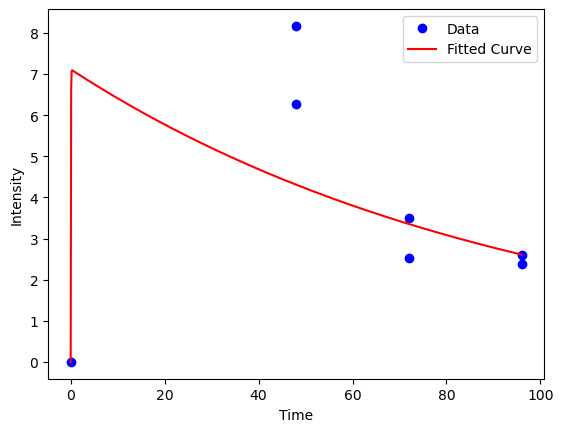

In [ ]:
# Plot the data and the fitted curve
fitted_t = np.linspace(time_data.min(),time_data.max(), 1000)
fitted_y = double_exponential_decay_c(fitted_t, *new_params)
plt.plot(time_data, concentration_data, 'bo', label='Data')
plt.plot(fitted_t, fitted_y, 'r-', label='Fitted Curve')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

In [ ]:
new_params

array([-22.09881753,   0.36034579,  16.3814921 ,   0.03749446,
         4.77664419])

# L2 loss as objective function and NLopt for optimization¶

In [ ]:
# Define model function for curve fit
def double_exponential_decay_c(t, a1, b1, a2, b2, c):
    return a1 * np.exp(- t * b1) + a2 * np.exp(- t * b2) + c

In [ ]:
# Define L2 loss function
def L2_loss(concentration_exp, concentration_pred):
    residuals = np.abs(concentration_exp - concentration_pred )
    return np.sum(residuals**2)

In [ ]:
# Define objective function for optimizer
def objective_function1(params, time_points, concentration):
    a1, b1, a2, b2, c = params
    model_function = double_exponential_decay_c(time_points, *params)
    loss2 = L2_loss(concentration, model_function)
    return loss2

In [ ]:
# Define initial params
#initial_params = [1., 1., 1., 1., 0.]
params_values = [-5, -1, 0, 1, 5]

In [ ]:
time_data = grouped_df_Merged_data.at[394, 'Time_points']
concentration_data = grouped_df_Merged_data.at[394, 'Concentrations']

print(f"time_data: {time_data}, concentration_data: {concentration_data}")

time_data: [  0.    0.5   2.    6.   24.  168. ], concentration_data: [ 0.    0.97  9.89 15.32 11.39  4.76]


In [ ]:
warnings.filterwarnings("ignore")
#params_values = [-5, 1, 0.1, 1, 5]
r2_optimal = 0
for a1 in params_values:
    for b1 in params_values:
        for a2 in params_values:
            for b2 in params_values:
                for c in params_values:
                    try:

                        initial_params = [a1, b1, a2, b2, c]
                        opt = nlopt.opt(nlopt.LN_NELDERMEAD, 5) # define the algorithm and parameters for optimization
                        opt.set_min_objective(lambda params, grad: objective_function1(params, time_data, concentration_data))
                        opt.set_xtol_rel(1e-4)  # Relative tolerance on the optimization
                        opt.set_maxeval(1000)   # Maximum number of function evaluations
                        optimized_params = opt.optimize(initial_params)
                        concentration_pred = double_exponential_decay_c(time_data, *optimized_params)
                        #print(f"optimized_params:{initial_params}")
                        #print(f"optimized_params:{optimized_params}")
                        #print(opt.last_optimize_result())
                        #print(opt.last_optimum_value())
                        r2_new = r2_score(concentration_data, concentration_pred)
                        if r2_new > r2_optimal:
                            new_params = optimized_params
                            r2_optimal = r2_new
                    except Exception:
                        nothing = 'nothing'
                        #print('fuck')




# Run the optimizer

#optimized_params = opt.optimize(initial_params)
#concentration_pred = double_exponential_decay_c(time_data, *optimized_params)
#R2 = r2_score(concentration_data, concentration_pred)
#print(f"r2_score: {R2}")

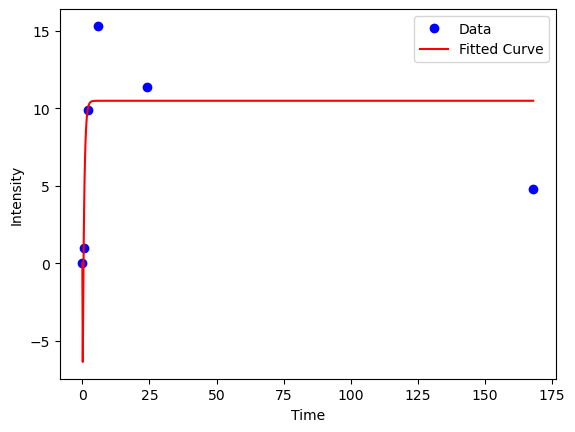

In [ ]:
# Plot the data and the fitted curve
fitted_t = np.linspace(time_data.min(),time_data.max(), 1000)
fitted_y = double_exponential_decay_c(fitted_t, *optimized_params)
plt.plot(time_data, concentration_data, 'bo', label='Data')
plt.plot(fitted_t, fitted_y, 'r-', label='Fitted Curve')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

# Huber loss with new double exponential decay

Optimized parameters: [ 8.50510871 17.21920783 -6.81535386 11.97003264  1.2659632 ]
Final loss: 9.71342225967432


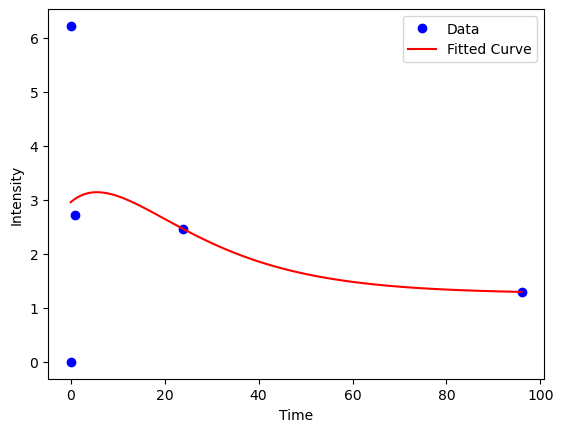

In [ ]:
warnings.filterwarnings("ignore")
# Define the double exponential decay model
def double_exponential_decay(t, A1, tau1, A2, tau2, C):
    return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + C

# Define the Huber loss function
def huber_loss(y_true, y_pred, delta):
    residual = np.abs(y_true - y_pred)
    is_small_error = residual <= delta
    small_error_loss = 0.5 * residual**2
    large_error_loss = delta * (residual - 0.5 * delta)
    return np.where(is_small_error, small_error_loss, large_error_loss).sum()

# Define the objective function for the optimizer
def objective(params, grad, t, y, delta):
    A1, tau1, A2, tau2, C = params
    model = double_exponential_decay(t, A1, tau1, A2, tau2, C)
    return huber_loss(y, model, delta)

# Generate sample data
t = grouped_df_Merged_data.at[421, 'Time_points']
y = grouped_df_Merged_data.at[421, 'Concentrations']


# Initial parameter guesses
initial_params = [1, 1, 1, 1, 0]
delta = 11
# Define the optimization problem
opt = nlopt.opt(nlopt.LN_NELDERMEAD, 5)  # 5 parameters to optimize
opt.set_min_objective(lambda params, grad: objective(params, grad,  t, y, delta))
opt.set_xtol_rel(1e-4)  # Relative tolerance on the optimization
opt.set_maxeval(1500)   # Maximum number of function evaluations

# Run the optimizer
optimized_params = opt.optimize(initial_params)
final_loss = opt.last_optimum_value()

print("Optimized parameters:", optimized_params)
print("Final loss:", final_loss)

# Plot the data and the fitted curve
fitted_t = np.linspace(t.min(),t.max(), 100)
fitted_y = double_exponential_decay(fitted_t, *optimized_params)
plt.plot(t, y, 'bo', label='Data')
plt.plot(fitted_t, fitted_y, 'r-', label='Fitted Curve')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()




Optimized parameters: [-1.21236631e+01  1.13767509e-08 -5.07215424e+00  4.84379627e+00
  1.74596290e+01]
RMSE: 3.9230863273610326
AAFE: inf
AFE: 2.9934519425101707
MUPE: inf


/var/folders/c9/k74z55jj3r56ql5kvxvq5q040000gn/T/ipykernel_4588/1882482981.py:7: RuntimeWarning: overflow encountered in exp
  return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + C
/var/folders/c9/k74z55jj3r56ql5kvxvq5q040000gn/T/ipykernel_4588/1882482981.py:13: RuntimeWarning: overflow encountered in square
  small_error_loss = 0.5 * residual**2
/var/folders/c9/k74z55jj3r56ql5kvxvq5q040000gn/T/ipykernel_4588/1882482981.py:36: RuntimeWarning: divide by zero encountered in divide
  aafe = np.mean(np.abs(y - model) / y)
/var/folders/c9/k74z55jj3r56ql5kvxvq5q040000gn/T/ipykernel_4588/1882482981.py:42: RuntimeWarning: divide by zero encountered in divide
  mupe = np.mean(np.abs((y - model) / y)) * 100


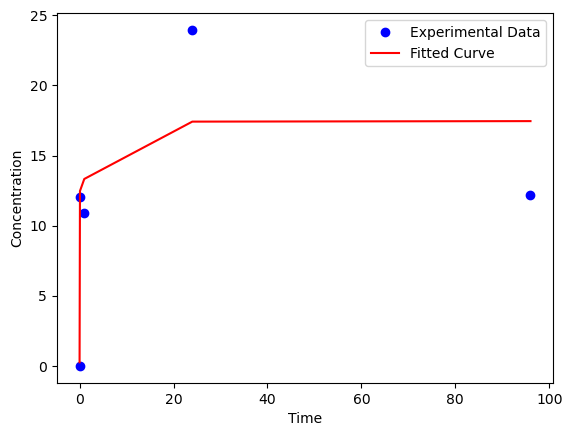

In [ ]:
import numpy as np
import nlopt
from sklearn.metrics import mean_squared_error

# Double exponential decay model function
def double_exponential_decay(t, A1, tau1, A2, tau2, C):
    return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + C

# Huber loss function
def huber_loss(y_true, y_pred, delta=10):
    residual = np.abs(y_true - y_pred)
    is_small_error = residual <= delta
    small_error_loss = 0.5 * residual**2
    large_error_loss = delta * (residual - 0.5 * delta)
    return np.where(is_small_error, small_error_loss, large_error_loss).sum()

# Objective function for NLopt, which uses Huber loss
def objective(params, grad, t, y, delta=10):
    A1, tau1, A2, tau2, C = params
    model = double_exponential_decay(t, A1, tau1, A2, tau2, C)

    # Huber loss
    loss = huber_loss(y, model, delta)

    return loss

# Calculate additional metrics
def calculate_metrics(params, t, y):
    A1, tau1, A2, tau2, C = params
    model = double_exponential_decay(t, A1, tau1, A2, tau2, C)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y, model))

    # Average Absolute Fitting Error (AAFE)
    aafe = np.mean(np.abs(y - model) / y)

    # Absolute Fitting Error (AFE)
    afe = np.mean(np.abs(y - model))

    # Mean Unsigned Percentage Error (MUPE)
    mupe = np.mean(np.abs((y - model) / y)) * 100

    return rmse, aafe, afe, mupe

# Sample experimental data (replace with your actual data)
t = grouped_df_Merged_data.at[422, 'Time_points']
y = grouped_df_Merged_data.at[422, 'Concentrations']

# Initial parameter guesses
initial_params = [1.0, 1.0, 1.0, 1.0, 0.0]

# Define the optimization problem
opt = nlopt.opt(nlopt.LN_NELDERMEAD, 5)  # 5 parameters to optimize
opt.set_min_objective(lambda params, grad: objective(params, grad, t, y))
opt.set_xtol_rel(1e-6)  # Relative tolerance on the optimization
opt.set_maxeval(1000)   # Maximum number of function evaluations

# Run the optimizer
optimized_params = opt.optimize(initial_params)

# Calculate metrics using the optimized parameters
rmse, aafe, afe, mupe = calculate_metrics(optimized_params, t, y)

# Print optimized parameters and metrics
print("Optimized parameters:", optimized_params)
print("RMSE:", rmse)
print("AAFE:", aafe)
print("AFE:", afe)
print("MUPE:", mupe)

# Optionally, plot the fitted curve and experimental data
import matplotlib.pyplot as plt
fitted_y = double_exponential_decay(t, *optimized_params)
plt.plot(t, y, 'bo', label='Experimental Data')
plt.plot(t, fitted_y, 'r-', label='Fitted Curve')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()


/var/folders/c9/k74z55jj3r56ql5kvxvq5q040000gn/T/ipykernel_4588/1695416879.py:7: RuntimeWarning: overflow encountered in exp
  return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + C
/var/folders/c9/k74z55jj3r56ql5kvxvq5q040000gn/T/ipykernel_4588/1695416879.py:36: RuntimeWarning: divide by zero encountered in divide
  aafe = np.mean(np.abs(y - model) / y)
/var/folders/c9/k74z55jj3r56ql5kvxvq5q040000gn/T/ipykernel_4588/1695416879.py:42: RuntimeWarning: divide by zero encountered in divide
  mupe = np.mean(np.abs((y - model) / y)) * 100
/var/folders/c9/k74z55jj3r56ql5kvxvq5q040000gn/T/ipykernel_4588/1695416879.py:7: RuntimeWarning: overflow encountered in exp
  return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + C
/var/folders/c9/k74z55jj3r56ql5kvxvq5q040000gn/T/ipykernel_4588/1695416879.py:13: RuntimeWarning: overflow encountered in square
  small_error_loss = 0.5 * residual**2
/var/folders/c9/k74z55jj3r56ql5kvxvq5q040000gn/T/ipykernel_4588/1695416879.py:36: RuntimeWarning: divi

Best Delta: 10
Corresponding Metrics (RMSE, AAFE, AFE, MUPE): (0.7433718441840381, inf, 0.53474555268382, inf)


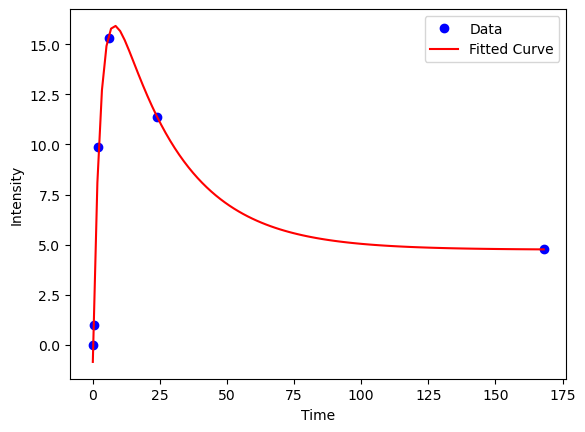

In [ ]:
import numpy as np
import nlopt
from sklearn.metrics import mean_squared_error

# Double exponential decay model function
def double_exponential_decay(t, A1, tau1, A2, tau2, C):
    return A1 * np.exp(-t / tau1) + A2 * np.exp(-t / tau2) + C

# Huber loss function
def huber_loss(y_true, y_pred, delta=1.0):
    residual = np.abs(y_true - y_pred)
    is_small_error = residual <= delta
    small_error_loss = 0.5 * residual**2
    large_error_loss = delta * (residual - 0.5 * delta)
    return np.where(is_small_error, small_error_loss, large_error_loss).sum()

# Objective function for NLopt, which uses Huber loss
def objective(params, grad, t, y, delta=1.0):
    A1, tau1, A2, tau2, C = params
    model = double_exponential_decay(t, A1, tau1, A2, tau2, C)

    # Huber loss
    loss = huber_loss(y, model, delta)

    return loss

# Calculate additional metrics
def calculate_metrics(params, t, y):
    A1, tau1, A2, tau2, C = params
    model = double_exponential_decay(t, A1, tau1, A2, tau2, C)

    # Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y, model))

    # Average Absolute Fitting Error (AAFE)
    aafe = np.mean(np.abs(y - model) / y)

    # Absolute Fitting Error (AFE)
    afe = np.mean(np.abs(y - model))

    # Mean Unsigned Percentage Error (MUPE)
    mupe = np.mean(np.abs((y - model) / y)) * 100

    return rmse, aafe, afe, mupe

# Sample experimental data (replace with your actual data)
t = grouped_df_Merged_data.at[394, 'Time_points']
y = grouped_df_Merged_data.at[394, 'Concentrations']

# Initial parameter guesses
initial_params = [1.0, 1.0, 1.0, 1.0, 0.0]

# Range of delta values to try
delta_values = [0.1, 1, 5, 10, 15, 20, 25]

# Initialize variables to store the best delta and corresponding metrics
best_delta = None
best_metrics = None

# Loop over delta values
for delta in delta_values:
    # Define the optimization problem
    opt = nlopt.opt(nlopt.LN_NELDERMEAD, 5)  # 5 parameters to optimize
    opt.set_min_objective(lambda params, grad: objective(params, grad, t, y, delta))
    opt.set_xtol_rel(1e-6)  # Relative tolerance on the optimization
    opt.set_maxeval(1000)   # Maximum number of function evaluations

    # Run the optimizer
    optimized_params = opt.optimize(initial_params)

    # Calculate metrics using the optimized parameters
    metrics = calculate_metrics(optimized_params, t, y)

    # Update best delta and metrics if necessary
    if best_metrics is None or metrics < best_metrics:
        best_delta = delta
        best_metrics = metrics

# Use the best delta for optimization
opt = nlopt.opt(nlopt.LN_NELDERMEAD, 5)  # 5 parameters to optimize
opt.set_min_objective(lambda params, grad: objective(params, grad, t, y, best_delta))
opt.set_xtol_rel(1e-6)  # Relative tolerance on the optimization
opt.set_maxeval(1000)   # Maximum number of function evaluations

# Run the optimizer with the best delta
optimized_params = opt.optimize(initial_params)

# Print the best delta and corresponding metrics
print("Best Delta:", best_delta)
print("Corresponding Metrics (RMSE, AAFE, AFE, MUPE):", best_metrics)

# Optionally, plot the fitted curve and experimental data
import matplotlib.pyplot as plt
fitted_t = np.linspace(t.min(),t.max(), 100)
fitted_y = double_exponential_decay(fitted_t, *optimized_params)
plt.plot(t, y, 'bo', label='Data')
plt.plot(fitted_t, fitted_y, 'r-', label='Fitted Curve')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()



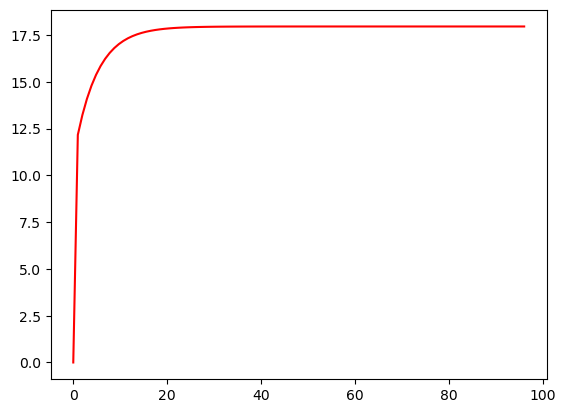

In [ ]:
plt.plot(fitted_t, fitted_y, 'r-', label='Fitted Curve')
plt.show()

In [ ]:
grouped_df_Merged_data.to_excel('Data_for_curve_fit.xlsx', index=False)

# Check double_exponential_decay with c

In [ ]:
# Define models for curve fitting
def double_exponential_decay(t, a1, b1, a2, b2, c):
    return a1 * np.exp(-b1 * t) + a2 * np.exp(-b2 * t) + c

### Check for all Organs except Blood

In [ ]:
warnings.filterwarnings("ignore")
# Create an empty DataFrame
df_curve_fit_organ = pd.DataFrame(columns=['Study_id', 'Instance', 'Organs', 'Concentrations', 'Time_points', 'Parameters', 'R2_score'])

# Initial values for curve_fit
params_values = [-5, 1, 0, 1, 5]

# Counter
#i = 1


# Iterate through grouped_df_Merged_data
with PdfPages('double_exponential_decay_organs(maxfev=200).pdf') as pdf:
    start_time = time.time()
    total_iterations = len(grouped_df_Merged_data)
    pbar = tqdm(total=total_iterations, desc="Fitting curves for Organs", leave=False)
    for index, row in grouped_df_Merged_data.iterrows():
        time_data = row['Time_points']
        concentration_data = row['Concentrations']

        if len(row['Concentrations']) >= 5 and row['Organs'] != 'Blood':
            r2_optimal = 0
            params = None

            for a1 in params_values:
                for b1 in params_values:
                    for a2 in params_values:
                        for b2 in params_values:
                            for c in params_values:
                                try:
                                    params, covariance = curve_fit(double_exponential_decay, time_data, concentration_data, p0 = (a1, b1, a2, b2, c), maxfev = 200)
                                    a1_fit, b1_fit, a2_fit, b2_fit, c_fit = params
                                    concentration_pred = double_exponential_decay(time_data, a1_fit, b1_fit, a2_fit, b2_fit, c_fit)
                                    r2_new = r2_score(concentration_data, concentration_pred)
                                    if r2_new > r2_optimal:
                                        new_params = params
                                        r2_optimal = r2_new

                                except Exception:
                                    nothing = 'nothing'

            time_curve = np.linspace(time_data.min(),time_data.max(), 100)
            concentration_curve = double_exponential_decay(time_curve, *new_params)
            # Plot the data points
            plt.scatter(time_data, concentration_data, label='Experimental data')
            plt.plot(time_curve, concentration_curve, color='red', label='Fitted Curve')
            # Add labels and legend
            plt.xlabel('Time points (hours)')
            plt.ylabel('Concentrations (%ID/g)')
            plt.title(f"Index:{index}, Study_id:{row['Study_id']}, Instance:{row['Instance']}, Organ:{row['Organs']}")
            plt.legend()

            # Save the plot to the PDF file
            pdf.savefig()
            plt.close()  # Close the plot to avoid displaying it in the loop


            #print(f"For Index:{index},  Study_id:{row['Study_id']}, Instance:{row['Instance']}, Organ:{row['Organs']} and R2_score:{r2_optimal} ")
            #i += 1
            df_curve_fit_organ.loc[index] = [row['Study_id'], row['Instance'], row['Organs'], concentration_data, time_data, new_params, r2_optimal]

        pbar.update(1)
    pbar.close()
    end_time = time.time()
    elapsed_time_seconds = end_time - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

# Download the PDF file
files.download('double_exponential_decay_organs(maxfev=200).pdf')

Elapsed time: 111.18 minutes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Check for Blood only

In [ ]:
warnings.filterwarnings("ignore")

# Initial values for curve_fit
params_values = [-5, 1, 0, 1, 5]


# Iterate through grouped_df_Merged_data
with PdfPages('double_exponential_decay_blood(maxfev=200).pdf') as pdf:
    start_time = time.time()
    total_iterations = len(grouped_df_Merged_data)
    pbar = tqdm(total=total_iterations, desc="Fitting curves for Blood", leave=False)

    for index, row in grouped_df_Merged_data.iterrows():
        time_data = row['Time_points']
        concentration_data = row['Concentrations']

        if len(row['Concentrations']) >= 5 and row['Organs'] == 'Blood':
            r2_optimal = 0
            params = None

            for a1 in params_values:
                for b1 in params_values:
                    for a2 in params_values:
                        for b2 in params_values:
                            for c in params_values:
                                try:
                                    params, covariance = curve_fit(double_exponential_decay, time_data, concentration_data, p0 = (a1, b1, a2, b2, c), maxfev = 200)
                                    a1_fit, b1_fit, a2_fit, b2_fit, c_fit = params
                                    concentration_pred = double_exponential_decay(time_data, a1_fit, b1_fit, a2_fit, b2_fit, c_fit)
                                    r2_new = r2_score(concentration_data, concentration_pred)
                                    if r2_new > r2_optimal:
                                        new_params = params
                                        r2_optimal = r2_new

                                except Exception:
                                    nothing = 'nothing'

            time_curve = np.linspace(time_data.min(),time_data.max(), 100)
            concentration_curve = double_exponential_decay(time_curve, *new_params)
            # Plot the data points
            plt.scatter(time_data, concentration_data, label='Experimental data')
            plt.plot(time_curve, concentration_curve, color='red', label='Fitted Curve')
            # Add labels and legend
            plt.xlabel('Time points (hours)')
            plt.ylabel('Concentrations (%ID/g)')
            plt.title(f"Index:{index}, Study_id:{row['Study_id']}, Instance:{row['Instance']}, Organ:{row['Organs']}")
            plt.legend()

            # Save the plot to the PDF file
            pdf.savefig()
            plt.close()  # Close the plot to avoid displaying it in the loop

            df_curve_fit_organ.loc[index] = [row['Study_id'], row['Instance'], row['Organs'], concentration_data, time_data, new_params, r2_optimal]





        pbar.update(1)

    pbar.close()
    end_time = time.time()
    elapsed_time_seconds = end_time - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

# Download the PDF file
files.download('double_exponential_decay_blood(maxfev=200).pdf')

Elapsed time: 15.23 minutes


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_curve_fit_organ.shape

(754, 7)

In [ ]:
# Make a copy of the Dataframe for saving
df_curve_fit_organ_double_exp_c = df_curve_fit_organ.copy()

# Convert NumPy arrays to lists and then to JSON strings
df_curve_fit_organ_double_exp_c['Concentrations'] = df_curve_fit_organ_double_exp_c['Concentrations'].apply(lambda x: json.dumps(x.tolist()))
df_curve_fit_organ_double_exp_c['Time_points'] = df_curve_fit_organ_double_exp_c['Time_points'].apply(lambda x: json.dumps(x.tolist()))
df_curve_fit_organ_double_exp_c['Parameters'] = df_curve_fit_organ_double_exp_c['Parameters'].apply(lambda x: json.dumps(x.tolist()))

# Save to CSV
df_curve_fit_organ_double_exp_c.to_csv('df_curve_fit_organ_double_exp_c.csv', index=True)

# Download the file
files.download('df_curve_fit_organ_double_exp_c.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
uploaded = files.upload()

Saving grouped_df_Merged_data.csv to grouped_df_Merged_data.csv


In [ ]:
# Reading the CSV
grouped_df_Merged_data = pd.read_csv('grouped_df_Merged_data.csv', index_col=0) # keep the original index

# Convert JSON strings back to lists
grouped_df_Merged_data['Concentrations'] = grouped_df_Merged_data['Concentrations'].apply(json.loads)
grouped_df_Merged_data['Time_points'] = grouped_df_Merged_data['Time_points'].apply(json.loads)

# Convert list back to Numpy arrays
grouped_df_Merged_data['Concentrations'] = grouped_df_Merged_data['Concentrations'].apply(np.array)
grouped_df_Merged_data['Time_points'] = grouped_df_Merged_data['Time_points'].apply(np.array)

print(grouped_df_Merged_data.shape)
grouped_df_Merged_data.head(5)

(2497, 6)


,Main_index,Study_id,Instance,Organs,Concentrations,Time_points
0,0,1,1,Blood,"[83.5715121429407, 2.457985651262957, 2.001502...","[0.0, 0.16666666666666666, 1.0, 2.0, 4.0, 24.0..."
1,0,1,1,Brain,"[0.0, 8.425676874874718, 2.9197890160456903, 2...","[0.0, 1.0, 24.0, 168.0]"
2,0,1,1,Kidneys,"[0.0, 7.995076681233775, 2.884821482919395, 2....","[0.0, 1.0, 24.0, 168.0]"
3,0,1,1,Liver,"[0.0, 3.4513788334293967, 9.20367688914503, 0....","[0.0, 1.0, 24.0, 168.0]"
4,0,1,1,Lungs,"[0.0, 7.259475430305388, 4.619666182921618, 56...","[0.0, 1.0, 24.0, 168.0]"


In [ ]:
uploaded = files.upload()

Saving df_curve_fit_organ_double_exp_c.csv to df_curve_fit_organ_double_exp_c (4).csv


In [ ]:
# Reading the CSV
df_curve_fit_organ_copy = pd.read_csv('df_curve_fit_organ_double_exp_c.csv', index_col=0) # keep the original index

# Convert JSON strings back to lists
df_curve_fit_organ_copy['Concentrations'] = df_curve_fit_organ_copy['Concentrations'].apply(json.loads)
df_curve_fit_organ_copy['Time_points'] = df_curve_fit_organ_copy['Time_points'].apply(json.loads)
df_curve_fit_organ_copy['Parameters'] = df_curve_fit_organ_copy['Parameters'].apply(json.loads)

# Convert list back to Numpy arrays
df_curve_fit_organ_copy['Concentrations'] = df_curve_fit_organ_copy['Concentrations'].apply(np.array)
df_curve_fit_organ_copy['Time_points'] = df_curve_fit_organ_copy['Time_points'].apply(np.array)
df_curve_fit_organ_copy['Parameters'] = df_curve_fit_organ_copy['Parameters'].apply(np.array)

print(df_curve_fit_organ_copy.shape)
df_curve_fit_organ_copy.head(5)

(754, 7)


,Study_id,Instance,Organs,Concentrations,Time_points,Parameters,R2_score
19,2,1,Bones,"[0.0, 0.59, 0.56, 0.53, 0.36, 0.46]","[0.0, 24.0, 72.0, 168.0, 360.0, 720.0]","[-0.6990155248713272, 0.10304154888035123, 0.2...",0.963459
20,2,1,Brain,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.0]","[0.0, 24.0, 72.0, 168.0, 360.0, 720.0]","[-1005.5373861857196, 1.4603303088206256, 1005...",1.000000
21,2,1,Heart,"[0.0, 0.14, 0.06, 0.05, 0.05, 0.06]","[0.0, 24.0, 72.0, 168.0, 360.0, 720.0]","[0.31399166513370236, 0.05363874844307148, -0....",0.993438
22,2,1,Intestine,"[0.0, 0.03, 0.04, 0.02, 0.01, 0.01]","[0.0, 24.0, 72.0, 168.0, 360.0, 720.0]","[-0.03911558086554343, 5.0, 0.0324966919593938...",0.863446
23,2,1,Kidneys,"[0.0, 0.28, 0.13, 0.08, 0.1, 0.08]","[0.0, 24.0, 72.0, 168.0, 360.0, 720.0]","[0.414096649885225, 0.03162586851881529, -0.50...",0.993108


# Check double_exponential_decay for Blood and exponential_decay for other organs

In [ ]:
df_curve_fit_organ_copy = df_curve_fit_organ.copy()
df_curve_fit_organ_copy.shape

(754, 7)

In [ ]:
# Define model for curve fitting
def double_exponential_decay1(t, a1, b1, a2, b2):
    return a1 * np.exp(-b1 * t) + a2 * np.exp(-b2 * t)

In [ ]:
def exponential_decay1(t, a1, b1, c):
    return a1 * np.exp(-b1 * t) + c

### Check for 'Blood' only with double_exponential_decay1

In [ ]:
warnings.filterwarnings("ignore")

# Initial values for curve_fit
params_values = [-5, 1, 0, 1, 5]


# Iterate through grouped_df_Merged_data
with PdfPages('double_exponential_decay1_blood(maxfev=500).pdf') as pdf:
    start_time = time.time()
    for index, row in grouped_df_Merged_data.iterrows():
        time_data = row['Time_points']
        concentration_data = row['Concentrations']

        if len(row['Concentrations']) == 4 and row['Organs'] == 'Blood':
            r2_optimal = 0
            params = None

            for a1 in params_values:
                for b1 in params_values:
                    for a2 in params_values:
                        for b2 in params_values:
                            try:
                                params, covariance = curve_fit(double_exponential_decay1, time_data, concentration_data, p0 = (a1, b1, a2, b2), maxfev = 500)
                                a1_fit, b1_fit, a2_fit, b2_fit = params
                                concentration_pred = double_exponential_decay1(time_data, a1_fit, b1_fit, a2_fit, b2_fit)
                                r2_new = r2_score(concentration_data, concentration_pred)
                                if r2_new > r2_optimal:
                                    new_params = params
                                    r2_optimal = r2_new

                            except Exception:
                                nothing = 'nothing'

            time_curve = np.linspace(time_data.min(),time_data.max(), 100)
            concentration_curve = double_exponential_decay1(time_curve, *new_params)
            # Plot the data points
            plt.scatter(time_data, concentration_data, label='Experimental data')
            plt.plot(time_curve, concentration_curve, color='red', label='Fitted Curve')
            # Add labels and legend
            plt.xlabel('Time points (hours)')
            plt.ylabel('Concentrations (%ID/g)')
            plt.title(f"Index:{index}, Study_id:{row['Study_id']}, Instance:{row['Instance']}, Organ:{row['Organs']}")
            plt.legend()

            # Save the plot to the PDF file
            pdf.savefig()
            plt.close()  # Close the plot to avoid displaying it in the loop


            print(f"For Index:{index},  Study_id:{row['Study_id']}, Instance:{row['Instance']}, Organ:{row['Organs']} and R2_score:{r2_optimal} ") #Progress:{i}/{1198}

            df_curve_fit_organ_copy.loc[index] = [row['Study_id'], row['Instance'], row['Organs'], concentration_data, time_data, new_params, r2_optimal]


    end_time = time.time()
    elapsed_time_seconds = end_time - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

# Download the file
files.download('double_exponential_decay1_blood(maxfev=500).pdf')


For Index:179,  Study_id:9, Instance:1, Organ:Blood and R2_score:1.0 
For Index:257,  Study_id:13, Instance:1, Organ:Blood and R2_score:1.0 
For Index:268,  Study_id:13, Instance:2, Organ:Blood and R2_score:0.9998970742530751 
For Index:279,  Study_id:13, Instance:3, Organ:Blood and R2_score:1.0 
For Index:290,  Study_id:13, Instance:4, Organ:Blood and R2_score:0.9983292490324153 
For Index:308,  Study_id:15, Instance:1, Organ:Blood and R2_score:1.0 
For Index:320,  Study_id:15, Instance:2, Organ:Blood and R2_score:1.0 
For Index:333,  Study_id:15, Instance:3, Organ:Blood and R2_score:1.0 
For Index:345,  Study_id:15, Instance:4, Organ:Blood and R2_score:0.9999998393816139 
For Index:448,  Study_id:19, Instance:4, Organ:Blood and R2_score:1.0 
For Index:484,  Study_id:21, Instance:1, Organ:Blood and R2_score:0.9999999534119013 
For Index:495,  Study_id:21, Instance:2, Organ:Blood and R2_score:1.0 
For Index:506,  Study_id:22, Instance:1, Organ:Blood and R2_score:1.0 
For Index:542,  St

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Check for 'Blood' only with exponential_decay1

In [ ]:
warnings.filterwarnings("ignore")

# Initial values for curve_fit
params_values = [-5, 1, 0, 1, 5]


# Iterate through grouped_df_Merged_data
with PdfPages('exponential_decay1_blood(maxfev=500).pdf') as pdf:
    start_time = time.time()
    for index, row in grouped_df_Merged_data.iterrows():
        time_data = row['Time_points']
        concentration_data = row['Concentrations']

        if len(row['Concentrations']) == 3 and row['Organs'] == 'Blood':
            r2_optimal = 0
            params = None

            for a1 in params_values:
                for b1 in params_values:
                    for c in params_values:

                      try:
                          params, covariance = curve_fit(exponential_decay1, time_data, concentration_data, p0 = (a1, b1, c), maxfev = 500)
                          a1_fit, b1_fit, c_fit = params
                          concentration_pred = exponential_decay1(time_data, a1_fit, b1_fit, c_fit)
                          r2_new = r2_score(concentration_data, concentration_pred)
                          if r2_new > r2_optimal:
                              new_params = params
                              r2_optimal = r2_new

                      except Exception:
                          nothing = 'nothing'

            time_curve = np.linspace(time_data.min(),time_data.max(), 100)
            concentration_curve = exponential_decay1(time_curve, *new_params)
            # Plot the data points
            plt.scatter(time_data, concentration_data, label='Experimental data')
            plt.plot(time_curve, concentration_curve, color='red', label='Fitted Curve')
            # Add labels and legend
            plt.xlabel('Time points (hours)')
            plt.ylabel('Concentrations (%ID/g)')
            plt.title(f"Index:{index}, Study_id:{row['Study_id']}, Instance:{row['Instance']}, Organ:{row['Organs']}")
            plt.legend()

            # Save the plot to the PDF file
            pdf.savefig()
            plt.close()  # Close the plot to avoid displaying it in the loop


            print(f"For Index:{index},  Study_id:{row['Study_id']}, Instance:{row['Instance']}, Organ:{row['Organs']} and R2_score:{r2_optimal} ") #Progress:{i}/{1198}

            df_curve_fit_organ_copy.loc[index] = [row['Study_id'], row['Instance'], row['Organs'], concentration_data, time_data, new_params, r2_optimal]


    end_time = time.time()
    elapsed_time_seconds = end_time - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

# Download the file
files.download('exponential_decay1_blood(maxfev=500).pdf')

For Index:732,  Study_id:31, Instance:1, Organ:Blood and R2_score:1.0 
For Index:885,  Study_id:40, Instance:1, Organ:Blood and R2_score:1.0 
For Index:899,  Study_id:40, Instance:2, Organ:Blood and R2_score:1.0 
For Index:921,  Study_id:41, Instance:1, Organ:Blood and R2_score:1.0 
For Index:957,  Study_id:42, Instance:1, Organ:Blood and R2_score:1.0 
For Index:971,  Study_id:42, Instance:2, Organ:Blood and R2_score:1.0 
For Index:993,  Study_id:43, Instance:1, Organ:Blood and R2_score:1.0 
For Index:1007,  Study_id:43, Instance:2, Organ:Blood and R2_score:1.0 
For Index:1362,  Study_id:58, Instance:4, Organ:Blood and R2_score:1.0 
For Index:1390,  Study_id:58, Instance:6, Organ:Blood and R2_score:1.0 
For Index:1798,  Study_id:81, Instance:1, Organ:Blood and R2_score:1.0 
For Index:1799,  Study_id:81, Instance:2, Organ:Blood and R2_score:1.0 
For Index:1800,  Study_id:81, Instance:3, Organ:Blood and R2_score:1.0 
For Index:1821,  Study_id:83, Instance:1, Organ:Blood and R2_score:1.0 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Check for organs except blood with exponential_decay1

In [ ]:
warnings.filterwarnings("ignore")

# Initial values for curve_fit
params_values = [-5, 1, 0, 1, 5]


# Iterate through grouped_df_Merged_data
with PdfPages('exponential_decay1_organs(maxfev=500).pdf') as pdf:
    start_time = time.time()
    for index, row in grouped_df_Merged_data.iterrows():
        time_data = row['Time_points']
        concentration_data = row['Concentrations']

        if len(row['Concentrations']) in [3, 4] and row['Organs'] != 'Blood':
            r2_optimal = 0
            params = None

            for a1 in params_values:
                for b1 in params_values:
                    for c in params_values:

                      try:
                          params, covariance = curve_fit(exponential_decay1, time_data, concentration_data, p0 = (a1, b1, c), maxfev = 500)
                          a1_fit, b1_fit, c_fit = params
                          concentration_pred = exponential_decay1(time_data, a1_fit, b1_fit, c_fit)
                          r2_new = r2_score(concentration_data, concentration_pred)
                          if r2_new > r2_optimal:
                              new_params = params
                              r2_optimal = r2_new

                      except Exception:
                          nothing = 'nothing'

            time_curve = np.linspace(time_data.min(),time_data.max(), 100)
            concentration_curve = exponential_decay1(time_curve, *new_params)
            # Plot the data points
            plt.scatter(time_data, concentration_data, label='Experimental data')
            plt.plot(time_curve, concentration_curve, color='red', label='Fitted Curve')
            # Add labels and legend
            plt.xlabel('Time points (hours)')
            plt.ylabel('Concentrations (%ID/g)')
            plt.title(f"Index:{index}, Study_id:{row['Study_id']}, Instance:{row['Instance']}, Organ:{row['Organs']}")
            plt.legend()

            # Save the plot to the PDF file
            pdf.savefig()
            plt.close()  # Close the plot to avoid displaying it in the loop


            print(f"For Index:{index},  Study_id:{row['Study_id']}, Instance:{row['Instance']}, Organ:{row['Organs']} and R2_score:{r2_optimal} ") #Progress:{i}/{1198}

            df_curve_fit_organ_copy.loc[index] = [row['Study_id'], row['Instance'], row['Organs'], concentration_data, time_data, new_params, r2_optimal]


    end_time = time.time()
    elapsed_time_seconds = end_time - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60
    print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

# Download the file
files.download('exponential_decay1_organs(maxfev=500).pdf')


For Index:1,  Study_id:1, Instance:1, Organ:Brain and R2_score:0.40162955572687586 
For Index:2,  Study_id:1, Instance:1, Organ:Kidneys and R2_score:0.4685438345915789 
For Index:3,  Study_id:1, Instance:1, Organ:Liver and R2_score:0.3041709806239874 
For Index:4,  Study_id:1, Instance:1, Organ:Lungs and R2_score:0.987679978690587 
For Index:5,  Study_id:1, Instance:1, Organ:Spleen and R2_score:0.7564629578880037 
For Index:7,  Study_id:1, Instance:2, Organ:Brain and R2_score:0.6093756093756096 
For Index:8,  Study_id:1, Instance:2, Organ:Kidneys and R2_score:0.6607856974829458 
For Index:9,  Study_id:1, Instance:2, Organ:Liver and R2_score:0.47250698974836924 
For Index:10,  Study_id:1, Instance:2, Organ:Lungs and R2_score:0.9235770629206035 
For Index:11,  Study_id:1, Instance:2, Organ:Spleen and R2_score:0.4608885901440545 
For Index:13,  Study_id:1, Instance:3, Organ:Brain and R2_score:0.5097606795719998 
For Index:14,  Study_id:1, Instance:3, Organ:Kidneys and R2_score:0.561832232

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_curve_fit_organ_copy.shape

(1440, 7)

In [ ]:
df_curve_fit_organ_copy.at[1000, 'Parameters']

array([-3.15923036, 38.32271773,  3.15923036])

In [ ]:
# Check the size of df_curve_fit_organ_copy
len(list3) + len(list4) + len(list5_more) == df_curve_fit_organ_copy.shape[0]

True

In [ ]:
# Make a copy of the Dataframe for saving
df_curve_fit_organ_for_save = df_curve_fit_organ_copy.copy()

# Convert NumPy arrays to lists and then to JSON strings
df_curve_fit_organ_for_save['Concentrations'] = df_curve_fit_organ_for_save['Concentrations'].apply(lambda x: json.dumps(x.tolist()))
df_curve_fit_organ_for_save['Time_points'] = df_curve_fit_organ_for_save['Time_points'].apply(lambda x: json.dumps(x.tolist()))
df_curve_fit_organ_for_save['Parameters'] = df_curve_fit_organ_for_save['Parameters'].apply(lambda x: json.dumps(x.tolist()))

# Save to CSV
df_curve_fit_organ_for_save.to_csv('df_curve_fit_organ.csv', index=True)

# Download the file
files.download('df_curve_fit_organ.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Reading the CSV
df_curve_fit_organ_loaded = pd.read_csv('df_curve_fit_organ_for_save.csv', index_col=0)
# Convert JSON strings back to lists
df_curve_fit_organ_loaded['Concentrations'] = df_curve_fit_organ_loaded['Concentrations'].apply(json.loads)
df_curve_fit_organ_loaded['Time_points'] = df_curve_fit_organ_loaded['Time_points'].apply(json.loads)
df_curve_fit_organ_loaded['Parameters'] = df_curve_fit_organ_loaded['Parameters'].apply(json.loads)
# Convert list back to Numpy arrays
df_curve_fit_organ_loaded['Concentrations'] = df_curve_fit_organ_loaded['Concentrations'].apply(np.array)
df_curve_fit_organ_loaded['Time_points'] = df_curve_fit_organ_loaded['Time_points'].apply(np.array)
df_curve_fit_organ_loaded['Parameters'] = df_curve_fit_organ_loaded['Parameters'].apply(np.array)

df_curve_fit_organ_loaded.head(5)

,Study_id,Instance,Organs,Concentrations,Time_points,Parameters,R2_score
19,2,1,Bones,"[0.0, 0.59, 0.56, 0.53, 0.36, 0.46]","[0.0, 24.0, 72.0, 168.0, 360.0, 720.0]","[0.28220198849386013, 0.008190106684799867, -0...",0.963459
20,2,1,Brain,"[0.0, 0.01, 0.0, 0.0, 0.0, 0.0]","[0.0, 24.0, 72.0, 168.0, 360.0, 720.0]","[-1005.5477244522068, 1.4603288971211954, 1005...",1.000000
21,2,1,Heart,"[0.0, 0.14, 0.06, 0.05, 0.05, 0.06]","[0.0, 24.0, 72.0, 168.0, 360.0, 720.0]","[-0.3673308356983923, 1.0, 0.31399166758199065...",0.993438
22,2,1,Intestine,"[0.0, 0.03, 0.04, 0.02, 0.01, 0.01]","[0.0, 24.0, 72.0, 168.0, 360.0, 720.0]","[0.03249669106929708, 0.004347846688744228, -0...",0.863446
23,2,1,Kidneys,"[0.0, 0.28, 0.13, 0.08, 0.1, 0.08]","[0.0, 24.0, 72.0, 168.0, 360.0, 720.0]","[-0.5004219149335754, 1.0, 0.4140966501938826,...",0.993108


In [ ]:
df_curve_fit_organ_loaded.at[19, 'Concentrations']

array([0.  , 0.59, 0.56, 0.53, 0.36, 0.46])

# Curve fitting with RMSE as objective function

In [ ]:
df_curve_fit_organ_final = df_curve_fit_organ_copy.copy()
df_curve_fit_organ_final.shape

(1439, 7)

In [ ]:
def rmse(predictions, observations):
    """
    Calculate the Root Mean Squared Error (RMSE).

    Parameters:
    predictions (list or np.array): Predicted values.
    observations (list or np.array): Observed values.

    Returns:
    float: The Root Mean Squared Error.
    """
    # Ensure inputs are numpy arrays
    y_obs = np.array(observations)
    y_pred = np.array(predictions)

    return np.sqrt(np.mean((y_pred - y_obs) ** 2))


In [ ]:
# Define objective function for optimizer
def objective_function(x, grad, time_data, concentration_data, metric):
    a1, b1, a2, b2, c = x
    model_function = double_exponential_decay(time_data, *x)
    loss = aafe(model_function, concentration_data) if metric == "AAFE" else rmse(model_function, concentration_data)
    return loss

### Optimize Blood parameters

In [ ]:
index_fit_list = [269, 291, 541, 1648, 1701, 1712, 1755, 1759, 2173, 2417, 2429,
                  780, 877, 1958]

In [ ]:
params_values = [-5,-1,0,1,5]

warnings.filterwarnings("ignore")

start_time = time.time()
total_iterations = len(index_fit_list)
pbar = tqdm(total=total_iterations, desc="Fitting curves for Blood", leave=False)


for index in index_fit_list:
    metric = 'RMSE' #"RMSE" OR "AAFE"
    metric_optimal = 1e+012
    # Define the experimental data
    time_data = df_curve_fit_organ_final.at[index, 'Time_points']
    concentration_data = df_curve_fit_organ_final.at[index, 'Concentrations']

    # Find the right parameters
    for a1 in params_values:
        for b1 in params_values:
            for a2 in params_values:
                for b2 in params_values:
                    for c in params_values:
                        try:

                            initial_params = [a1, b1, a2, b2, c]
                            opt = nlopt.opt(nlopt.LN_SBPLX, 5) # define the algorithm and parameters for optimization
                            opt.set_min_objective(lambda params, grad: objective_function(params, grad, time_data, concentration_data, metric))
                            #opt.set_min_objective(lambda params, grad: objective_function(params, time_data, concentration_data))
                            opt.set_xtol_rel(1e-6)  # Relative tolerance on the optimization
                            opt.set_maxeval(50)   # Maximum number of function evaluations
                            optimized_params = opt.optimize(initial_params)

                            concentration_pred = double_exponential_decay(time_data, *optimized_params)

                            if metric == "AAFE":
                                metric_new = aafe(concentration_pred, concentration_data)
                            elif metric == "RMSE":
                                metric_new = rmse(concentration_pred, concentration_data)

                            if metric_new < metric_optimal:
                                new_params = optimized_params
                                metric_optimal = metric_new

                        except Exception:
                            nothing = 'nothing'


    # Replace with the updated parameters
    df_curve_fit_organ_final.at[index, 'Parameters'] = new_params


    # Replace with the updated R2_score
    concentration_pred = double_exponential_decay(time_data, *new_params)
    R2_score = r2_score(concentration_data, concentration_pred)
    df_curve_fit_organ_final.at[index, 'R2_score'] = R2_score

    pbar.update(1)
pbar.close()
end_time = time.time()
elapsed_time_seconds = end_time - start_time
elapsed_time_minutes = elapsed_time_seconds / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")



Fitting curves for Blood: 100%|██████████| 14/14 [01:03<00:00,  4.72s/it]
                                                                         

Elapsed time: 1.06 minutes


In [ ]:
with PdfPages('blood_plots_optimized_RMSE.pdf') as pdf:
    for index in index_fit_list:

        time_data = df_curve_fit_organ_final.at[index, 'Time_points']
        concentration_data = df_curve_fit_organ_final.at[index, 'Concentrations']

        time_curve = np.linspace(time_data.min(),time_data.max(), 1000)


        concentration_curve = double_exponential_decay(time_curve, *df_curve_fit_organ_final.at[index, 'Parameters'])




        # Plot the data points
        plt.scatter(time_data, concentration_data, label='Experimental data')
        plt.plot(time_curve, concentration_curve, color='red', label='Fitted Curve')
        # Add labels and legend
        plt.xlabel('Time points (hours)')
        plt.ylabel('Concentrations (%ID/g)')
        plt.title(f"Index:{index}, Study_id:{df_curve_fit_organ_final.at[index, 'Study_id']}, Instance:{df_curve_fit_organ_final.at[index, 'Instance']}, Organ:{df_curve_fit_organ_final.at[index, 'Organs']}")
        plt.legend()

        # Save the plot to the PDF file
        pdf.savefig()
        plt.close()

### Optimize other organs parameters

In [ ]:
# Create an empty list to store the index
index_fit_list_organ = []

for index, row in df_curve_fit_organ_final.iterrows():
    if row['R2_score'] <= 0.95 and row['Organs'] != 'Blood':
        index_fit_list_organ.append(index)

index_fit_list_organ.sort()

print(f"There are {len(index_fit_list_organ)} set of parameters that need optimization")

There are 565 set of parameters that need optimization


### Decision: optimization of sets of parameters in 4 batches

In [ ]:
# Calculate the length of each sublist
batch_length = len(index_fit_list_organ) // 4

# Divide the list into four sublists
batch_1 = index_fit_list_organ[:batch_length]
batch_2 = index_fit_list_organ[batch_length:2*batch_length]
batch_3_1 = index_fit_list_organ[2*batch_length:(2*batch_length+60)]
batch_3_2 = index_fit_list_organ[(2*batch_length+60):(2*batch_length+90)]
batch_3_3 = index_fit_list_organ[(2*batch_length+90):3*batch_length]
batch_4 = index_fit_list_organ[3*batch_length:]

# Print the lengths of the sublists
print(f"Batch_1 has {len(batch_1)} sets of parameters for optimization")
print(f"Batch_2 has {len(batch_2)} sets of parameters for optimization")
print(f"Batch_3 has {len(batch_3_3)} sets of parameters for optimization")
print(f"Batch_4 has {len(batch_4)} sets of parameters for optimization")

Batch_1 has 141 sets of parameters for optimization
Batch_2 has 141 sets of parameters for optimization
Batch_3 has 51 sets of parameters for optimization
Batch_4 has 142 sets of parameters for optimization


In [ ]:
params_values = [-5,-1,0,1,5]

warnings.filterwarnings("ignore")
batch_list = batch_3_3

start_time = time.time()
total_iterations = len(batch_list)
pbar = tqdm(total=total_iterations, desc="Fitting curves for Organs", leave=False)


for index in batch_list:
    metric = 'RMSE' #"RMSE" OR "AAFE"
    metric_optimal = 1e+012
    # Define the experimental data
    time_data = df_curve_fit_organ_final.at[index, 'Time_points']
    concentration_data = df_curve_fit_organ_final.at[index, 'Concentrations']

    # Find the right parameters
    for a1 in params_values:
        for b1 in params_values:
            for a2 in params_values:
                for b2 in params_values:
                    for c in params_values:
                        try:

                            initial_params = [a1, b1, a2, b2, c]
                            opt = nlopt.opt(nlopt.LN_SBPLX, 5) # define the algorithm and parameters for optimization
                            opt.set_min_objective(lambda params, grad: objective_function(params, grad, time_data, concentration_data, metric))
                            #opt.set_min_objective(lambda params, grad: objective_function(params, time_data, concentration_data))
                            opt.set_xtol_rel(1e-4)  # Relative tolerance on the optimization
                            opt.set_maxeval(600)   # Maximum number of function evaluations
                            optimized_params = opt.optimize(initial_params)

                            concentration_pred = double_exponential_decay(time_data, *optimized_params)

                            if metric == "AAFE":
                                metric_new = aafe(concentration_pred, concentration_data)
                            elif metric == "RMSE":
                                metric_new = rmse(concentration_pred, concentration_data)

                            if metric_new < metric_optimal:
                                new_params = optimized_params
                                metric_optimal = metric_new

                        except Exception:
                            pass


    # Replace with the updated parameters
    df_curve_fit_organ_final.at[index, 'Parameters'] = new_params


    # Replace with the updated R2_score
    concentration_pred = double_exponential_decay(time_data, *new_params)
    R2_score = r2_score(concentration_data, concentration_pred)
    df_curve_fit_organ_final.at[index, 'R2_score'] = R2_score

    pbar.update(1)
pbar.close()
end_time = time.time()
elapsed_time_seconds = end_time - start_time
elapsed_time_minutes = elapsed_time_seconds / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")


Elapsed time: 51.66 minutes


In [ ]:
with PdfPages('organ_plots_RMSE_batch3_3.pdf') as pdf:
    for index in batch_list:

        time_data = df_curve_fit_organ_final.at[index, 'Time_points']
        concentration_data = df_curve_fit_organ_final.at[index, 'Concentrations']

        time_curve = np.linspace(time_data.min(),time_data.max(), 1000)


        concentration_curve = double_exponential_decay(time_curve, *df_curve_fit_organ_final.at[index, 'Parameters'])




        # Plot the data points
        plt.scatter(time_data, concentration_data, label='Experimental data')
        plt.plot(time_curve, concentration_curve, color='red', label='Fitted Curve')
        # Add labels and legend
        plt.xlabel('Time points (hours)')
        plt.ylabel('Concentrations (%ID/g)')
        plt.title(f"Index:{index}, Study_id:{df_curve_fit_organ_final.at[index, 'Study_id']}, Instance:{df_curve_fit_organ_final.at[index, 'Instance']}, Organ:{df_curve_fit_organ_final.at[index, 'Organs']}")
        plt.legend()

        # Save the plot to the PDF file
        pdf.savefig()
        plt.close()

In [ ]:
# Make a copy of the Dataframe for saving
df_curve_fit_organ_final_for_save = df_curve_fit_organ_final.copy()

# Convert NumPy arrays to lists and then to JSON strings
df_curve_fit_organ_final_for_save['Concentrations'] = df_curve_fit_organ_final_for_save['Concentrations'].apply(lambda x: json.dumps(x.tolist()))
df_curve_fit_organ_final_for_save['Time_points'] = df_curve_fit_organ_final_for_save['Time_points'].apply(lambda x: json.dumps(x.tolist()))
df_curve_fit_organ_final_for_save['Parameters'] = df_curve_fit_organ_final_for_save['Parameters'].apply(lambda x: json.dumps(x.tolist()))

# Save to CSV
df_curve_fit_organ_final_for_save.to_csv('df_curve_fit_organ_final_for_save.csv', index=True)